# Springboard Intermediate Datascience - Capstone Project
## Housing price prediction based on web data
How accurate can our housing price prediction be, based on a few data scraped from the web ? In this project, I'll try using data I scraped on a belgian real-estate website (approx. 500 observations), from houses spread all around belgium. With this data, I'll assess whether I can obtain a fair model to predict housing price. <br>
I'll also try dealing with the data without too much thinking about how it can impact the model, then I'll do it with the help a of real-estate professionnal and assess whether I can obtain a better model or not.

#### Preliminary notes:
Here we work with annonced prices, but not saleprices. We'll therfore predict annonced prices and not saleprices. 
People often tend to ask for too much when they sell their house.

Many people like to negociate. Maybe the ideal model should propose a price based on the saleprice but not the annonced one. It should indicate the saleprice and give a price to annonce so that people can negociate (people like it and feel good when they feel like they get a deal).


# DATA WRANGLING

## Importing the data and cleaning

### Important Note: the following shows first what I did without and then with the real-estate expert's advice.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('scraped_data.csv')

# display bigger figures in line
mpl.rcParams['figure.figsize'] = (10,10)
mpl.style.use('fivethirtyeight')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Columns: 110 entries, Address to Year of construction
dtypes: float64(21), object(89)
memory usage: 421.2+ KB


Scraping the data lead me to obtain a lot of different features (110), for not that many observations (490). Depending on the person who gave the information, the amount of features is very different from one observation to another. Let's have a look at the best-filled features (with the lower NaN rate).
<br><br>
Let's have a quick look at the dataframe:

In [3]:
is_count = df.count()
#let's keep only features with 75% filled values:
to_keep = is_count.index[is_count.values>(0.75*len(df))]
print('We initially had {0:1d} features, but we can now keep {1:1d} [75% filled].'.format(len(is_count.index),len(to_keep)))

We initially had 110 features, but we can now keep 29 [75% filled].


Still, we may have to clean some more because some features may not be relevant. Let's have a look:

In [4]:
to_keep = to_keep.tolist()
print(to_keep)

['Address', 'As built plan', 'As property tenant or owner, insure your real estate: fire, theft, water damage, storm, ...', 'Available as of', 'Bathrooms', 'Bedroom 1 area', 'Bedrooms', 'Building condition', 'Cadastral income', 'Double glazing', 'EPC - Energy consumption', 'Find the mortgage formula and a borrowing rate that suits you the best!', 'Heating', 'Inspection report of the electrical installation', 'Kitchen setup', 'Living room', 'Net floor area', 'Number of frontages', 'Planning permission obtained', 'Plot area', 'Possible priority purchase right', 'Proceedings for breach of planning regulations', 'Reference number of the EPC report', 'Requested sale price', 'Subdivision permit', 'Terrace', 'To ensure your payments and your family safety in case of early death, you can take a Decreasing life insurance.', 'Toilets', 'Year of construction']


In this list, we see "Living room", but not "Living room area" --> The area is more relevant to us and we'll therefore drop "Living room" (boolean) and add "Living room area"

In [5]:
to_keep.append('Living room area')
to_keep.remove('Living room')

Here are the other features we can remove: 'As built plan','As property tenant or owner, insure your real estate: fire, theft, water damage, storm, ...','Available as of','Find the mortgage formula and a borrowing rate that suits you the best!','Planning permission obtained','Possible priority purchase right','Proceedings for breach of planning regulations','Reference number of the EPC report'

<b>Note: </b>keeping features where I have too few observations will be difficult to manage and very uncertain (how should I fill nan's ?). I'd rather keep the features with a lot of observations for two reasons:
<ul>
  <li>People completed these information based on what is relevant to the buyer. I therefore expect these features to have a higher impact on the price;</li>
  <li>The more information I have, the better for my model</li>
</ul>

These can be removed because they either are not relevant, or most of the observations are "Not Specified".

In [6]:
list_remove = ['As built plan','As property tenant or owner, insure your real estate: fire, theft, water damage, storm, ...','Available as of','Find the mortgage formula and a borrowing rate that suits you the best!','Planning permission obtained','Possible priority purchase right','Proceedings for breach of planning regulations','Reference number of the EPC report','To ensure your payments and your family safety in case of early death, you can take a Decreasing life insurance.','Subdivision permit']
print("To remove: {0:1d}".format(len(list_remove)))
for ft in list_remove:
    if ft in to_keep:
        to_keep.remove(ft)
print("Kept: {0:1d}".format(len(to_keep)))

To remove: 10
Kept: 19


In [7]:
#Let's make a copy and keep a clean version of the dataframe at this point
df1 = df[to_keep].copy()

Let's now look at the different features and try to clean/fill the dataframe

In [8]:
df1.columns

Index(['Address', 'Bathrooms', 'Bedroom 1 area', 'Bedrooms',
       'Building condition', 'Cadastral income', 'Double glazing',
       'EPC - Energy consumption', 'Heating',
       'Inspection report of the electrical installation', 'Kitchen setup',
       'Net floor area', 'Number of frontages', 'Plot area',
       'Requested sale price', 'Terrace', 'Toilets', 'Year of construction',
       'Living room area'],
      dtype='object')

In [9]:
df1.head(3)

,Address,Bathrooms,Bedroom 1 area,Bedrooms,Building condition,Cadastral income,Double glazing,EPC - Energy consumption,Heating,Inspection report of the electrical installation,Kitchen setup,Net floor area,Number of frontages,Plot area,Requested sale price,Terrace,Toilets,Year of construction,Living room area
0,Tongersesteenweg 205 | 3770 - Riemst,1.0,18 m2,3.0,Good condition,€ 873,yes,380 kWh/m2,Fuel,"yes, conform",Semi-equipped,250 m2,4.0,"1,880 m2","€ 299,000",yes,2.0,1969.0,46 m2
1,Kerkstraat 122 | 2870 - Puurs,1.0,28 m2,3.0,To be renovated,"€ 1,110",yes,576 kWh/m2,Gas,"yes, not conform",Installed,338 m2,3.0,470 m2,"€ 239,000",yes,3.0,1965.0,73 m2
2,Avenue du Putdael 3 | 1150 - Woluwe-Sai...,5.0,26 m2,4.0,As new,"€ 4,858",yes,304 kWh/m2,Gas,"yes, conform",USA Hyper-equipped,335 m2,4.0,794 m2,"€ 1,590,000",yes,5.0,1950.0,32 m2


We can clean numeric data and scale text data for some features. We'll do this for:
<ul>
  <li>Price</li>
  <li>Plot area</li>
  <li>Bathrooms</li>
  <li>Bedroom 1 area</li>
  <li>Bedrooms</li>
  <li>Building condition</li>
  <li>Cadastral income</li>
  <li>Double glazing</li>
  <li>EPC - Energy consumption</li>
  <li>Heating --> OneHotEncode ?</li>
  <li>Inspection report of the electrical installation</li>
  <li>Kitchen setup --> OneHoteEncode ?</li>
  <li>Living room</li>
  <li>Net floor area</li>
  <li>Number of frontages</li>
  <li>Terrace</li>
  <li>Toilets</li>
  <li>Year of construction</li>

</ul>


Many features can be treated the same way:

In [10]:
#Listing features for which 0's can be repalced with median (to me):
zero_median = ['Price','Plot area','Bathrooms','Bedroom 1 area','Bedrooms','Cadastral income','EPC - Energy consumption',\
              'Living room area','Net floor area','Number of frontages','Toilets','Year of construction']

But let's first clean each feature separately:

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 19 columns):
Address                                             490 non-null object
Bathrooms                                           463 non-null float64
Bedroom 1 area                                      368 non-null object
Bedrooms                                            489 non-null float64
Building condition                                  467 non-null object
Cadastral income                                    452 non-null object
Double glazing                                      383 non-null object
EPC - Energy consumption                            472 non-null object
Heating                                             451 non-null object
Inspection report of the electrical installation    403 non-null object
Kitchen setup                                       429 non-null object
Net floor area                                      482 non-null object
Number of frontages          

All non-float features that should be numeric need to be cleaned ! <br>
Cadastral income, EPC, Living room area, Net floor area, Sale price, Plot Area, Bedroom 1 area, Toilets <br>
We'll first fill all missing values (Nan bu also others) with zeros. Then, we'll be able to easily replace all the zeros with appropriate numerics.

#### Price:

In [12]:
#What does the price look like ?
df1['Requested sale price'].sample(5)

416    € 189,950
296    € 265,000
211    € 485,000
392    € 415,000
297    € 498,000
Name: Requested sale price, dtype: object

We need to get rid of the € sign, as well as of the commas.

In [13]:
#no need for data if no house price !! 
df1 =df1[pd.notnull(df['Requested sale price'])].copy()
df1['Price'] = [int(x.strip("€").strip().replace(',','')) for x in df1['Requested sale price']]
df1.drop('Requested sale price',axis=1)
df1['Price'].sample(5)

151    310000
445    545000
448    350000
34     299000
42     275000
Name: Price, dtype: int64

Any missing values ?

In [14]:
df1['Price'].isnull().sum()

0

We have no missing values for Price !<br>
Any 0's ?

In [15]:
sum(df1['Price']==0)

0

In [16]:
#Remove requested sale price column:
df1.drop('Requested sale price', axis=1, inplace=True)

#### Plot area:

In [17]:
#What does the plot area look like ?
df1['Plot area'].sample(5)

332    3,110 m2
138    1,475 m2
129    1,127 m2
481      752 m2
75       183 m2
Name: Plot area, dtype: object

It is given with commas and "m2" at the end. Let's make it an integer.

In [18]:
#If NaN, then place '0 m2'
df1[['Plot area']] = df1[['Plot area']].fillna('0 m2')
df1['Plot area'] = [int(y.replace('m2','').strip().replace(',','')) for y in df1['Plot area']]
df1['Plot area'].sample(5)

111       0
436     161
186     560
400    1597
145    1000
Name: Plot area, dtype: int64

In [19]:
#Missing values ?
df1['Plot area'].isnull().sum()

0

<br>
(Bathrooms is of type float64 and no cleaning is required.)
#### Bedroom 1 area:

In [20]:
df1['Bedroom 1 area'].sample(3)

30       NaN
159    33 m2
204    23 m2
Name: Bedroom 1 area, dtype: object

"m²" needs to be removed so that we have a type int.

In [21]:
df1[['Bedroom 1 area']] = df1[['Bedroom 1 area']].fillna('0 m2')
df1['Bedroom 1 area'] = [int(y.replace('m2','').strip().replace(',','')) for y in df1['Bedroom 1 area']]
df1['Bedroom 1 area'].sample(3)

306    17
84     17
341    15
Name: Bedroom 1 area, dtype: int64

#### Net Floor Area:

In [22]:
df1['Net floor area'].sample(3)

382      250 m2
351      346 m2
250    1,037 m2
Name: Net floor area, dtype: object

In [23]:
df1[['Net floor area']] = df1[['Net floor area']].fillna('0 m2')
df1['Net floor area'] = [int(y.replace('m2','').strip().replace(',','')) for y in df1['Net floor area']]
df1['Net floor area'].sample(3)

319    152
116    316
329    167
Name: Net floor area, dtype: int64

#### Living room area:

In [24]:
df1['Living room area'].sample(3)

174      NaN
451    27 m2
461      NaN
Name: Living room area, dtype: object

In [25]:
df1[['Living room area']] = df1[['Living room area']].fillna('0 m2')
df1['Living room area'] = [int(y.replace('m2','').strip().replace(',','')) for y in df1['Living room area']]
df1['Living room area'].sample(3)

452    58
203    32
189     0
Name: Living room area, dtype: int64

#### EPC - Energy consumption:

In [26]:
df1['EPC - Energy consumption'].sample(3)

390    621 kWh/m2
123    354 kWh/m2
478    190 kWh/m2
Name: EPC - Energy consumption, dtype: object

In [27]:
df1['EPC - Energy consumption'].replace('not specified',np.nan,inplace=True) #some observations are "not specified". Replaced by NaN
df1[['EPC - Energy consumption']] = df1[['EPC - Energy consumption']].fillna('0 kWh/m2')
df1['EPC - Energy consumption'] = [int(y.replace('kWh/m2','').strip().replace(',','')) for y in df1['EPC - Energy consumption']]
df1['EPC - Energy consumption'].sample(3)

224    222
335    284
135    302
Name: EPC - Energy consumption, dtype: int64

#### Cadastral income:

In [28]:
df1['Cadastral income'].sample(3)

95       € 609
164    € 1,824
268      € 880
Name: Cadastral income, dtype: object

In [29]:
df1['Cadastral income'] = df1['Cadastral income'].fillna('0')
df1['Cadastral income'] = [int(x.replace('€','').strip().replace(',','')) for x in df1['Cadastral income']]
df1['Cadastral income'].sample(3)

152     530
313    2464
63     1846
Name: Cadastral income, dtype: int64

#### Bathrooms : 
As seen previously: Bathrooms 463 non-null float64<br>
We only need to fill missing values for now.

In [30]:
df1['Bathrooms'] = df1['Bathrooms'].fillna('0')

### Filling all the zeroes:
We'll replace all zeros with the median for each column. It is not a problem here as we only kept features with a few missing values.
We can do this with Bedrooms, Number of frontages, Toilets, Year of construction.

In [31]:
#first let's make sure all Nan's have been converted to zeros in these columns: 
numerics = ['Price','Plot area','Cadastral income','EPC - Energy consumption','Living room area','Net floor area',\
            'Bedroom 1 area','Toilets','Bedrooms','Number of frontages','Year of construction','Bathrooms']
for ft in  numerics:
    df1[ft]=df1[ft].astype(float)
    if df1[ft].isnull().sum() != 0: #if we have some Nans
        df1[ft].fillna(0,inplace=True)
    df1[ft][df1[ft]==0] = np.median(df1[ft])

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 19 columns):
Address                                             488 non-null object
Bathrooms                                           488 non-null float64
Bedroom 1 area                                      488 non-null float64
Bedrooms                                            488 non-null float64
Building condition                                  465 non-null object
Cadastral income                                    488 non-null float64
Double glazing                                      381 non-null object
EPC - Energy consumption                            488 non-null float64
Heating                                             449 non-null object
Inspection report of the electrical installation    401 non-null object
Kitchen setup                                       427 non-null object
Net floor area                                      488 non-null float64
Number of frontages      

All cleaned features now have 488 non-null values.

In [33]:
#Function to plot count of features:
def display_count(df,feature):
    from collections import Counter
    count = Counter(df[feature])
    df_count = pd.DataFrame.from_dict(count, orient='index')
    df_count.columns = ['Count']
    df_count = df_count.sort_values('Count',ascending=False)
    df_count.plot(kind='bar')
    plt.title('Count of ' + feature)
    plt.show()

#### Building Condition

In [34]:
df1['Building condition'].isnull().sum()

23

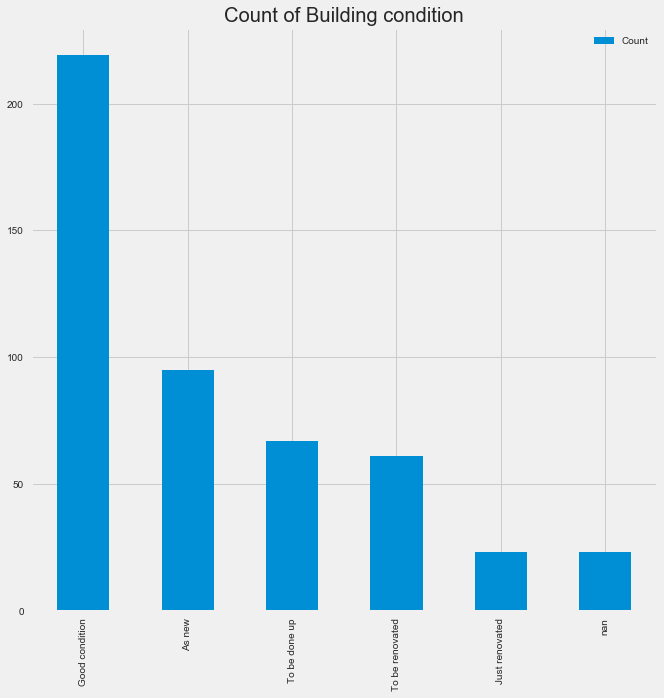

In [35]:
display_count(df1,'Building condition')

Let's consider Nan to be in good condition, as it is the most common state.
But house condition is subjective. Maybe it would be better to not consider this as an owner will probably set it at his advantage ? I don't know..

In [36]:
df1['Building condition'] = df1['Building condition'].fillna('Good condition')

In [37]:
df1['Building condition'].isnull().sum()

0

#### Double Glazing

Maybe gthis criteria is correlated to energy consumption, with heating. Indeed, based on heating an glazing, the consumption will increase/decrease accordingly.

In [38]:
df1['Double glazing'].isnull().sum()

107

This feature either gives YES or Nan --> As double glazing is really important for the buyer, I expect every seller to notify it if there is (it is not something you forget to mention). Therefore all blanks represent the 'No' answer.

In [39]:
df1['Double glazing'] = df1['Double glazing'].fillna('no')

In [40]:
df1['Double glazing'].isnull().sum()

0

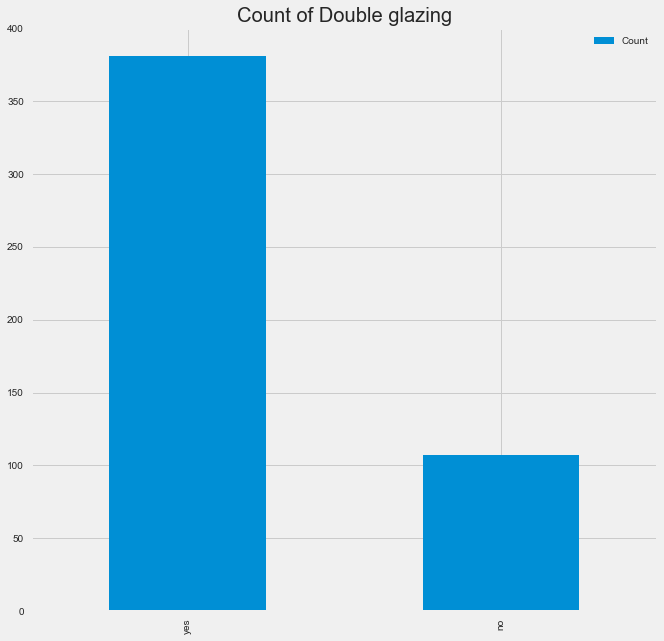

In [41]:
display_count(df1,'Double glazing')

#### Kitchen Setup

Transofr into boolean --> Equipped or not.

Equipped = Installed, USA Hyper equipped, USA installed, Hyper-equipped
Non-equipped = Semi-equipped, Uninstalled, USA semi-equipped

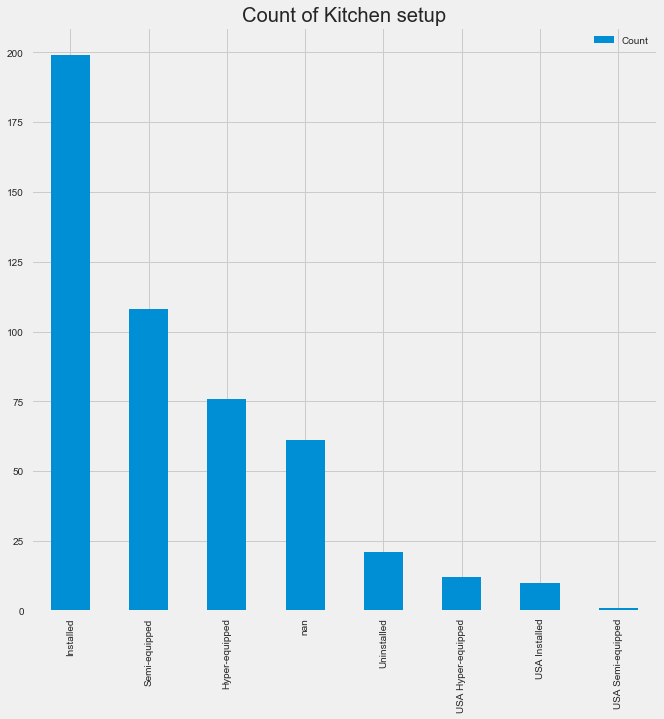

In [42]:
display_count(df1,'Kitchen setup')

"Installed" seems to be default for the houses. Let's fill nans with "Installed". 

In [43]:
df1['Kitchen setup'] = df1['Kitchen setup'].fillna('Installed')

#### Heating: 

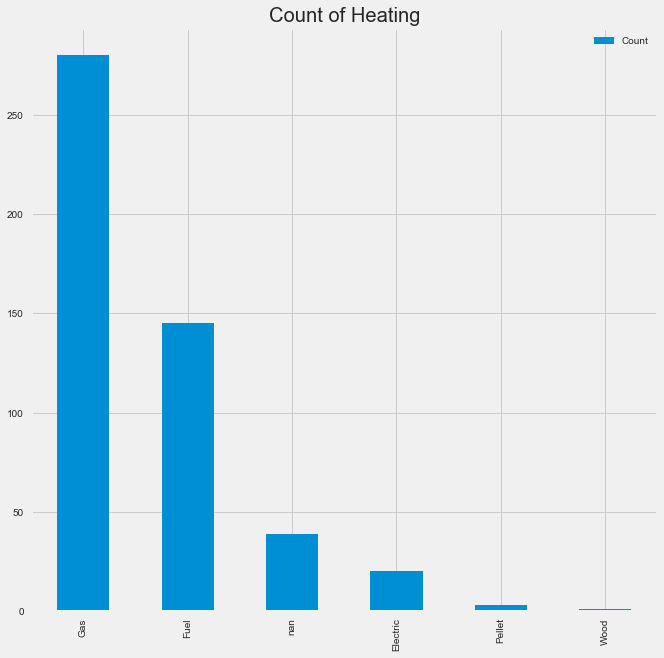

In [44]:
display_count(df1,'Heating')

Heating is mosly gas --> Let's fill the few Nan's with 'Gas':

In [45]:
df1['Heating'] = df1['Heating'].fillna('Gas')

#### Inspection report of the electrical installation

As for double glazing, we expect owners with a conform electrical installation to mention it as it is a value adder for the house. We'll consider all Nan's to be 'no'.

In [46]:
df1['Inspection report of the electrical installation'] = df1['Inspection report of the electrical installation'].fillna('no')

#### Terrace
Same as above.

In [47]:
df1['Terrace'] = df1['Terrace'].fillna('no')

In [48]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 19 columns):
Address                                             488 non-null object
Bathrooms                                           488 non-null float64
Bedroom 1 area                                      488 non-null float64
Bedrooms                                            488 non-null float64
Building condition                                  488 non-null object
Cadastral income                                    488 non-null float64
Double glazing                                      488 non-null object
EPC - Energy consumption                            488 non-null float64
Heating                                             488 non-null object
Inspection report of the electrical installation    488 non-null object
Kitchen setup                                       488 non-null object
Net floor area                                      488 non-null float64
Number of frontages      

### Encoding : 
Now that we have our dataframe completed, let's work a bit more on the non-numeric entries so that we can use these for the model.

In [49]:
df2 = df1.copy()

In [50]:
df2 = pd.get_dummies(df2,columns=['Building condition','Double glazing','Kitchen setup','Heating','Terrace','Inspection report of the electrical installation'], prefix=['condition','double_glazing','kitchen','heating','terrace','elec_report'])

In [51]:
df2.head()

,Address,Bathrooms,Bedroom 1 area,Bedrooms,Cadastral income,EPC - Energy consumption,Net floor area,Number of frontages,Plot area,Toilets,...,heating_Electric,heating_Fuel,heating_Gas,heating_Pellet,heating_Wood,terrace_no,terrace_yes,elec_report_no,"elec_report_yes, conform","elec_report_yes, not conform"
0,Tongersesteenweg 205 | 3770 - Riemst,1.0,18.0,3.0,873.0,380.0,250.0,4.0,1880.0,2.0,...,0,1,0,0,0,0,1,0,1,0
1,Kerkstraat 122 | 2870 - Puurs,1.0,28.0,3.0,1110.0,576.0,338.0,3.0,470.0,3.0,...,0,0,1,0,0,0,1,0,0,1
2,Avenue du Putdael 3 | 1150 - Woluwe-Sai...,5.0,26.0,4.0,4858.0,304.0,335.0,4.0,794.0,5.0,...,0,0,1,0,0,0,1,0,1,0
3,Elie Aubinaustraat 29 | 1932 - Zaventem,1.0,14.0,5.0,899.0,687.0,189.0,3.0,1220.0,1.0,...,0,0,1,0,0,1,0,0,0,1
4,Dendermondsesteenweg 20 | 2830 - Willeb...,1.0,13.0,2.0,255.0,164.0,120.0,2.0,115.0,2.0,...,0,0,1,0,0,0,1,0,1,0


#### Taking care of the location:
Let's first try a model without longitude and latitude. We'll then see if we can improve our model with precise location.

In [52]:
df1['Address'] = [y.replace('|','').strip() for y in df1['Address']]
df1['Address']=[' '.join(y.split()) for y in df1['Address']]
df1['Address']=[y.replace('Ask for the exact address','') for y in df1['Address']]

In [53]:
# #Address --> Lat. Long.

# import os
# from geopy import geocoders
# from geopy.geocoders import GoogleV3

# cpt=1

# API_KEY = os.getenv("API1234")
# g = GoogleV3(API_KEY)

# loc_coordinates = []
# loc_address = []
# for address in df1.Address:
#     try:
#         inputAddress = address
#         location = g.geocode(inputAddress)
#         loc_coordinates.append((location.latitude, location.longitude))
#         loc_address.append(inputAddress)
#     except Exception as e:
#         print('{0:1d} : '.format(cpt), address, e)
#         cpt+=1

# df_geocodes = pd.DataFrame({'coordinate':loc_coordinates,'address':loc_address})

As we have very few observations spread all around belgium, let's drop this feature.

In [54]:
df1.drop('Address',axis=1,inplace=True)

## Notes from the real-estate expert:

<ul>
  <li>EPC : in the following, we'll also consider heating and glazing. Altogether, these 3 variables are somehow redundant. The EPC score is calculated based on - among other things - galzing and heating. For our expert's dataframe (let's call it this way), we'll drop this variable.</li>
  <li>Cadastral income: maybe we should not consider cadastral income in the analysis, as it is a consequence of the house price. But we could use it to check whether our tool worked properly. If the difference is too big between house price estimated with cadastral income and house price estimated with our tool, then we can display some text saying that there is a mismatch. If it's quite concording, it can increase confidence in the model.</li>
  <li>Year of construct : makes no sense as a really old house can be renovated and therefore be super great. it is not advised to take this into account !</li>
  <li>Indoor parking spaces: this feature should be kept as it is really important to people living downtown. All missing values can be replaced with zero as we can expect the seller to mention it if there is one.</li>
  <li>Kitchen setup: this criteria can be seen as boolean (equipped or not). Nan's are not equipped.</li>
<li>Heating: this variable is almost binary. Gas and fuel are nice to have, but having other forms of heating has no added value when you decide to buy a house. For example, buying electric heaters is cheap but costs a lot to use.</li>
<li>Toilets/bathrooms: every house has at least one toilet/bathroom. This feature could be seen as a boolen where having multiple toilets/bathrooms is (1) and having one is standard (0).</li>
</ul>

<b>Additional notes:</b> 
<ul>
    <li>Here we work with annonced prices and not saleprices. We'll therefore predict annonced prices. This information is to interpret carefully as people often tend to ask for too much for their house. Furthermore, buyers like to negociate and feel like they make a good deal. A good model should give the saleprice and indicate a good price to annonce so that the required saleprice is reached.</li>
</ul>

<br><br>

### Expert's dataframe ["_e"]
Let's now take all these advices into account, and build our expert's dataframe.

In [55]:
df1_e = df1.copy()

We need to clean differently for Kitchen setup, Heating, Toilets, Bathrooms. Building condition, EPC Energy consumption, cadastral income, year of construct can be dropped.

In [56]:
#Replacing already cleaning features with initial data + adding parking spaces
df1_e['Kitchen setup'] = df['Kitchen setup']
df1_e['Heating'] = df['Heating']
df1_e['Toilets']= df['Toilets']
df1_e['Bathrooms']= df['Bathrooms']
df1_e['Indoor parkings'] = df['Indoor parking spaces']

#Dropping features
df1_e.drop('EPC - Energy consumption',axis=1,inplace=True)
df1_e.drop('Cadastral income',axis=1,inplace=True)
df1_e.drop('Year of construction',axis=1,inplace=True)
df1_e.drop('Building condition',axis=1,inplace=True)
df1_e.drop('Inspection report of the electrical installation',axis=1,inplace=True)

In [57]:
df1_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 14 columns):
Bathrooms              461 non-null float64
Bedroom 1 area         488 non-null float64
Bedrooms               488 non-null float64
Double glazing         488 non-null object
Heating                449 non-null object
Kitchen setup          427 non-null object
Net floor area         488 non-null float64
Number of frontages    488 non-null float64
Plot area              488 non-null float64
Terrace                488 non-null object
Toilets                458 non-null float64
Living room area       488 non-null float64
Price                  488 non-null float64
Indoor parkings        320 non-null float64
dtypes: float64(10), object(4)
memory usage: 57.2+ KB


We still have 15 features. Now time for cleaning, according to above advices.
#### Toilets and Bathrooms
One is standard (0), multiple is a value adder (1).

In [58]:
#Filling missing values with 1, as we consider no house has been built without capability for a bathroom/Toilet
df1_e['Toilets'] = df1_e['Toilets'].astype(str).astype(float)
df1_e['Bathrooms'] = df1_e['Bathrooms'].astype(str).astype(float)

df1_e['Toilets'] = df1_e['Toilets'].fillna(float('1'))
df1_e['Bathrooms'] = df1_e['Bathrooms'].fillna(float('1'))

#All 1's --> 0. All >1 --> 1
df1_e['Toilets'][df1_e['Toilets']==1] = float(0) 
df1_e['Toilets'][df1_e['Toilets']>1] = float(1) 

df1_e['Bathrooms'][df1_e['Bathrooms']==1] = float(0) 
df1_e['Bathrooms'][df1_e['Bathrooms']>1] = float(1) 

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipyke

In [59]:
df1_e['Bathrooms'].sample(4)

306    0.0
403    1.0
249    0.0
254    0.0
Name: Bathrooms, dtype: float64

#### Heating
Gas and fuel = 1. Others = 0.

In [60]:
#Not specified = 0
df1_e['Heating']=df1_e['Heating'].fillna(0)

df1_e['Heating'] = [1 if h in ['Gas','Fuel'] else 0 for h in df1_e['Heating']]

df1_e['Heating'].sample(3)

306    1
415    1
157    1
Name: Heating, dtype: int64

#### Kitchen setup
Is the kitchen equipped (1) or not ?

In [61]:
#Not specified = 0
df1_e['Kitchen setup']=df1_e['Kitchen setup'].fillna(0)

df1_e['Kitchen setup'] = [1 if k in ['Installed','USA Hyper-equipped','USA Installed','Hyper-equipped'] else 0 \
                          for k in df1_e['Kitchen setup']]

In [62]:
df1_e['Kitchen setup'].sample(5)

352    1
23     1
329    1
400    0
191    0
Name: Kitchen setup, dtype: int64

#### Indoor Parking Spaces
This is a really important feature for people living in cities especially. We'll have three stages: not having indoor parking spaces, having one and aving multiple ones.

In [63]:
df1_e['Indoor parkings']=df1_e['Indoor parkings'].fillna(0)
df1_e['Indoor parkings']=[2 if p > 1 else p for p in df1_e['Indoor parkings']]

In [64]:
df1_e['Indoor parkings'].sample(5)

331    0.0
400    2.0
62     1.0
305    2.0
101    2.0
Name: Indoor parkings, dtype: float64

In [65]:
df1_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 14 columns):
Bathrooms              488 non-null float64
Bedroom 1 area         488 non-null float64
Bedrooms               488 non-null float64
Double glazing         488 non-null object
Heating                488 non-null int64
Kitchen setup          488 non-null int64
Net floor area         488 non-null float64
Number of frontages    488 non-null float64
Plot area              488 non-null float64
Terrace                488 non-null object
Toilets                488 non-null float64
Living room area       488 non-null float64
Price                  488 non-null float64
Indoor parkings        488 non-null float64
dtypes: float64(10), int64(2), object(2)
memory usage: 57.2+ KB


In [66]:
#Let's keep a clean dataframe as backup and use df2_e (as we'll use df2 as well)
df2_e = df1_e.copy()

In [67]:
df2_e = pd.get_dummies(df2_e,columns=['Double glazing','Terrace'], \
                       prefix=['double_glazing','terrace'])

In [68]:
df2_e.head(5)

,Bathrooms,Bedroom 1 area,Bedrooms,Heating,Kitchen setup,Net floor area,Number of frontages,Plot area,Toilets,Living room area,Price,Indoor parkings,double_glazing_no,double_glazing_yes,terrace_no,terrace_yes
0,0.0,18.0,3.0,1,0,250.0,4.0,1880.0,1.0,46.0,299000.0,2.0,0,1,0,1
1,0.0,28.0,3.0,1,1,338.0,3.0,470.0,1.0,73.0,239000.0,1.0,0,1,0,1
2,1.0,26.0,4.0,1,1,335.0,4.0,794.0,1.0,32.0,1590000.0,2.0,0,1,0,1
3,0.0,14.0,5.0,1,0,189.0,3.0,1220.0,0.0,14.0,350000.0,1.0,1,0,1,0
4,0.0,13.0,2.0,1,1,120.0,2.0,115.0,1.0,24.0,195000.0,0.0,0,1,0,1


### Let's now have a look at the data and remove eventual outliers

In [69]:
#Histogram of Price:

from scipy import stats
from scipy.stats import norm

def normality_check(df,feature):
    sns.distplot(df[feature] , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[feature])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(str(feature) + ' distribution')

    fig = plt.figure()
    res = stats.probplot(df[feature], plot=plt)
    plt.show()

    print("Skewness: %f" % df[feature].skew())
    print("Kurtosis: %f" % df[feature].kurt())


 mu = 450178.79 and sigma = 427155.88



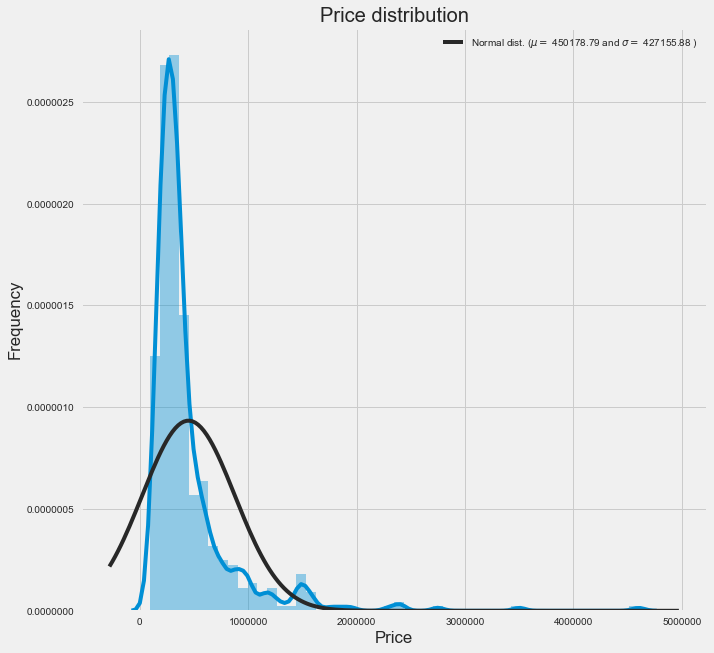

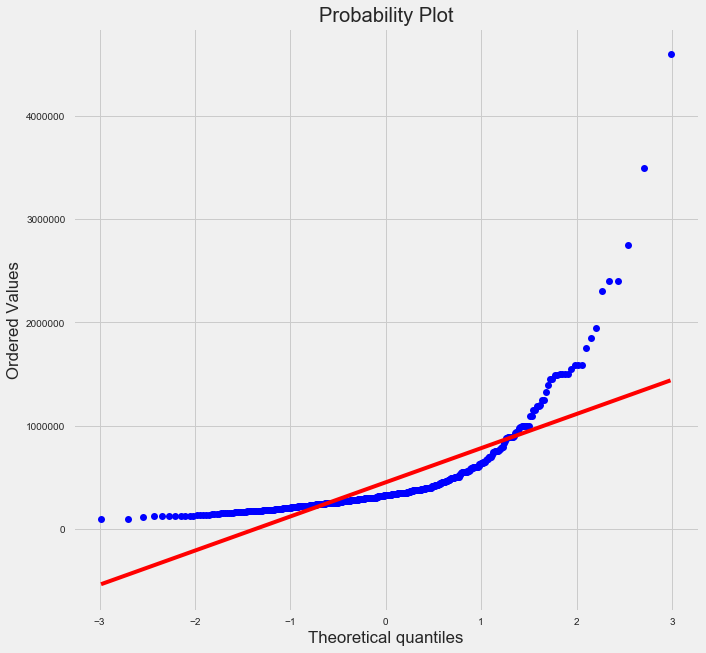

Skewness: 4.244211
Kurtosis: 27.153788


In [70]:
normality_check(df2,'Price')

The histogram is clear, our distribution is significantly different from normal distribution with same median and stdev.
Also, we can see on the probability plot that we do not have a normal distribution (normal is in red, ours in blue). <br>
A normal distribution has a Skewness of zero --> Here we have 4.24 which confirms it is not normal. The high kurtosis tells us we have a lot of weight in the tails (combined). <br>
<b>For now:</b> let's keep the data as it is. Later, we'll try to make it more normal to see if we can improve our results !

# DATA STORYTELLING

### 1. Can you count something interesting ?
### 2. Can you find some trends ?
### 3. Can you make a bar plot or histogram ?
### 4. Can you compare two related quantities ?
### 5. Can you make a scatterplot ?
### 6. Can you make a time-series plot ?

Let's try answering all of these questions ! <b>First with our initial dataframe, then we'll do the same with the expert's dataframe !</b><br>

As already done above, count of different features has been done so that we can have an idea of how well each occurence is represented. But now that data is cleaned, it'd be interesting to understand how the data relate to each other, and mainly to price.<br><br>
We'll always start by asking questions, and then try to find an answer.

In [71]:
df1.columns

Index(['Bathrooms', 'Bedroom 1 area', 'Bedrooms', 'Building condition',
       'Cadastral income', 'Double glazing', 'EPC - Energy consumption',
       'Heating', 'Inspection report of the electrical installation',
       'Kitchen setup', 'Net floor area', 'Number of frontages', 'Plot area',
       'Terrace', 'Toilets', 'Year of construction', 'Living room area',
       'Price'],
      dtype='object')

<b>Which features are the more correlated with Price ?</b>
Let's look at the heatmap !

In [72]:
#Heatmap to display correlation
def display_heatmap(df,feature):
    k = 11 #number of variables for heatmap
    corrmat = df.corr()
    cols = corrmat.nlargest(k, feature)[feature].index
    cm = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

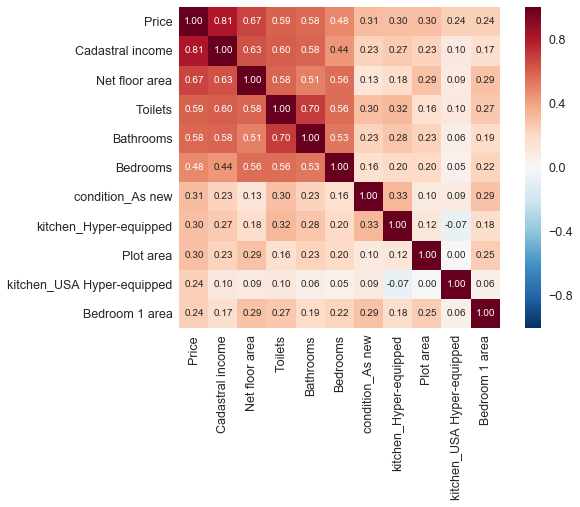

In [73]:
#For basic dataframe
display_heatmap(df2,'Price')

We can easily identify 5 features: cadastral income, net floor area, toilets, bathrooms and bedrooms. <br>
Cadastral income is highly correlated, as explained by the real-estate professional. Number of toilets seems highly correlated to price. Still, it is quite odd as nobody would by a house twice the price if the number of toilets is doubled. <br>
<b>How do cadastral income an price relate ?</b>

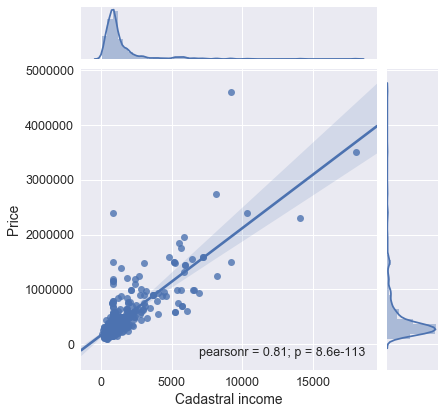

In [74]:
sns.jointplot(x=df2['Cadastral income'],y=df2['Price'],kind='reg')
plt.show()

We have few really expensive houses. These are badly represented in our sample and we'll therefore get rid of these (= removing outliers in our case). Let's take care of houses with really high prices but surpisingly low cadastral incomes.

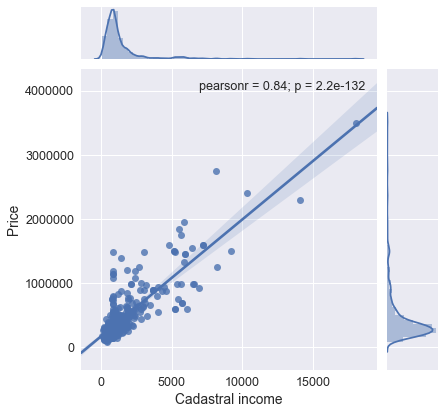

In [75]:
df2 = df2.drop(df2[(df2['Cadastral income']>9000) & (df2['Price']>4000000)].index).reset_index(drop=True)
df2 = df2.drop(df2[(df2['Cadastral income']<1000) & (df2['Price']>2000000)].index).reset_index(drop=True)

sns.jointplot(x=df2['Cadastral income'],y=df2['Price'],kind='reg')
plt.show()

Correlation improved. Still, we can see thanks to the density plots on the side that most of our data represent houses priced below 1e6€ and with a cadastral inferior to 5000€. <br>
<b>Are all bigger houses more expansive than smaller ones ?</b>

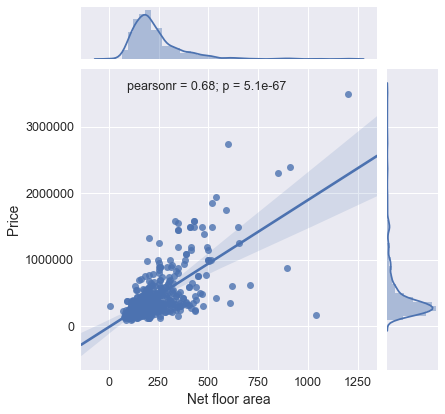

In [76]:
sns.jointplot(x=df2['Net floor area'],y=df2['Price'],kind='reg')
plt.show()

We can observe some really big houses (>600 m²) with a price quite low. These houses are probably in really bad condition (and also not well represented in this dataset). Let's get rid of these !

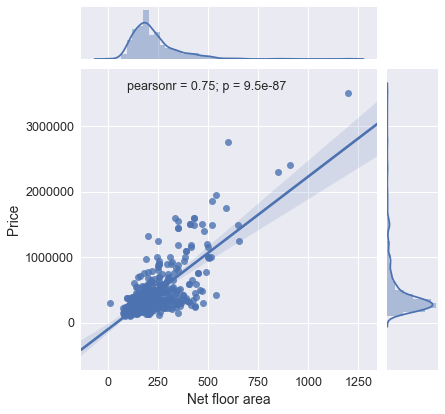

In [77]:
df2 = df2.drop(df2[(df2['Net floor area']>600) & (df2['Price']<1000000)].index).reset_index(drop=True)
sns.jointplot(x=df2['Net floor area'],y=df2['Price'],kind='reg')
plt.show()

The trend is quite clear: if you want a big house, get ready to empty your wallet. <br>
<b>Can we have an idea of the house price in regards of the number of toilets it contains ?</b>

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


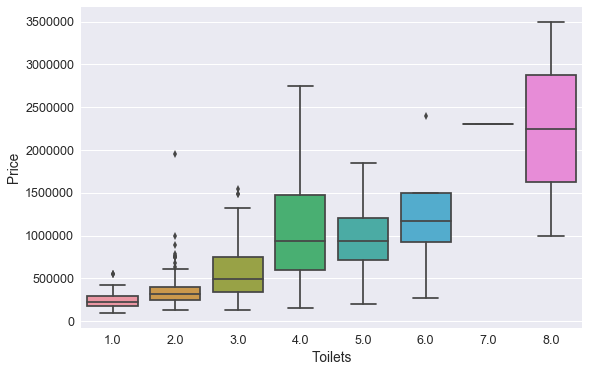

In [78]:
sns.boxplot(x=df2['Toilets'], y=df2['Price'])
plt.show()

At first, we could say yes. Because we can see a trend: the more toilets, the higher the price. But min and max widely spread, and boxes are quite tall, sometimes overlapping. Even by looking at the medians, we see that for 4,5 or 6 toilets, it makes almost no difference. Maybe we have really few data with a lot of toilets:

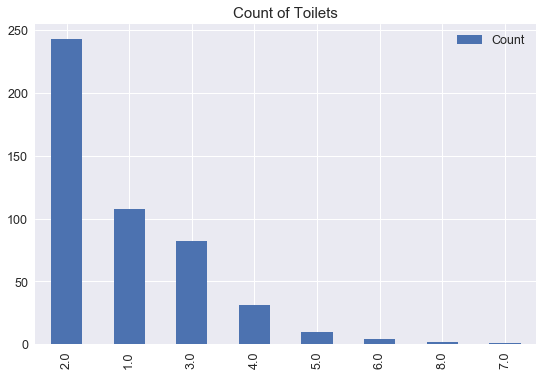

In [79]:
display_count(df2,'Toilets')

Indeed, we cannot rely on a high number of toilets as there are not many observations. Also, as we'll see further, the real-estate professional explained that the price does not increase because there are more toilets but because the house is bigger ! Having more toilets is a consequence of having a really big house.
<br><b>Can we conclude the same for bathrooms ?</b>

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


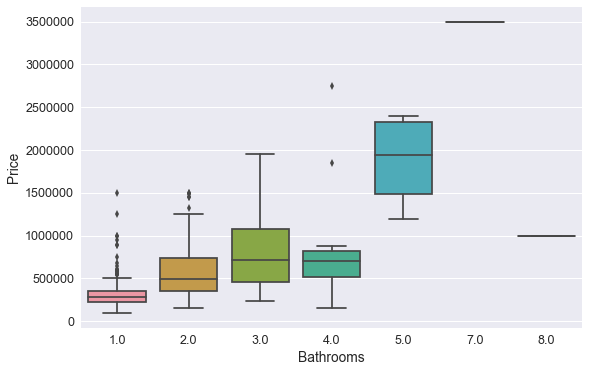

In [80]:
sns.boxplot(x=df2['Bathrooms'], y=df2['Price'])
plt.show()

I'll remove houses with 7 and 8 bathrooms. These are probably really big houses and are not common. I'll therefore have too few data for this segment of the population (big and expensive houses) and I'd rather have a model working properly on average houses than a model barely working for all houses !

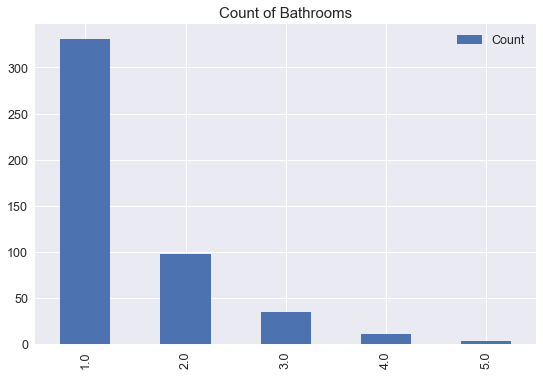

In [81]:
df2 = df2.drop(df2[(df2['Bathrooms']>6)].index).reset_index(drop=True)
display_count(df2,'Bathrooms')

Most houses have only one bathroom ! <br>
<b>Do bedrooms follow the same trend ?</b>

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


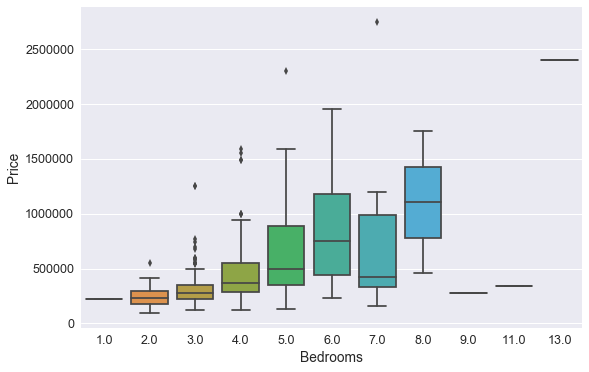

In [82]:
sns.boxplot(x=df2['Bedrooms'], y=df2['Price'])
plt.show()

It looks like so ! But contrary to toilets and bathrooms, you can have a house not that big with a consequent number of rooms (to fit all family members for example). Having 5 rooms does not require multiple bathrooms.<br>
Let's get rid of houses with more than 9 bedrooms as they are not well represented:

In [83]:
df2 = df2.drop(df2[(df2['Bedrooms']>=9)].index).reset_index(drop=True)

<b>I expect a house to be more expensive if its state is "As new". Is it the case ?</b>

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


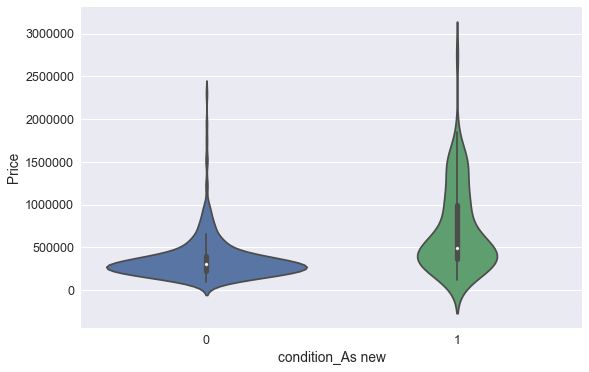

In [84]:
sns.violinplot(x=df2['condition_As new'], y=df2['Price'])
plt.show()

Houses in perfect condition are more expensive ! As mentioned by the <b>expert</b>, this criteria is highly subjective. Still, the trend is quite clear here.<br>
<b>How does plot area compare to net floor area ?</b>

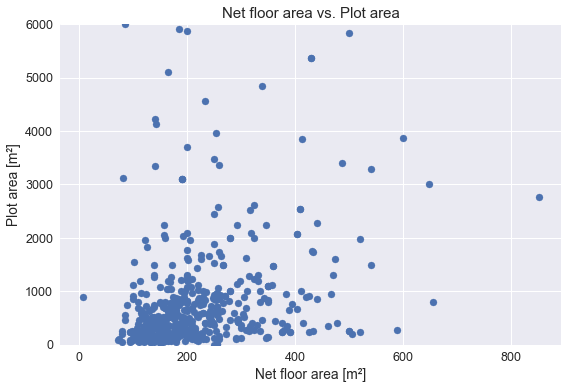

In [85]:
plt.scatter(df2['Net floor area'],df2['Plot area'])
plt.xlabel('Net floor area [m²]')
plt.ylabel('Plot area [m²]')
plt.title('Net floor area vs. Plot area')
plt.ylim([0,6000])
plt.show()

We cannot see a clear trend between these two features, and it makes sense. Indeed, you can have a small house on a big plot, or a big house on a small plot (obviously not bigger than the plot itself). <br>
<b>Globally, are newer houses sold more than older ones ?</b> This criteria does not take into account whether the house has been renovated or not, its current state,...
<br>
Since data is not normally distributed, we'll used the median and not the mean.

In [86]:
y_temp = df2.groupby('Year of construction')['Price'].median()

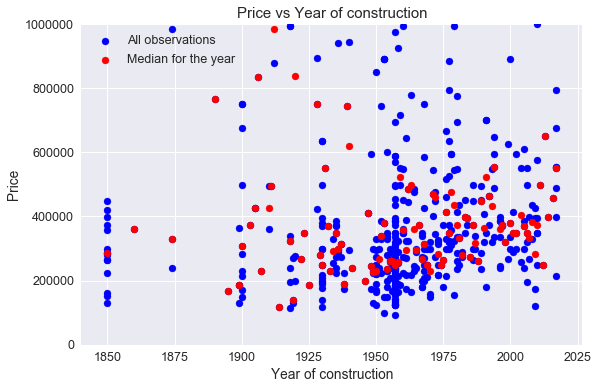

In [87]:
plt.scatter(df2['Year of construction'],df2['Price'],color='blue',label='All observations')
plt.scatter(y_temp.index,y_temp,color='red',label='Median for the year')
plt.xlabel('Year of construction')
plt.ylabel('Price')
plt.title('Price vs Year of construction')
plt.ylim([0,1000000])
plt.legend()
plt.show()

No specific trend can be observed ! It means year of construction is not directly linked to price. Indeed, you can renovate an old house, or have a quite new house in a really bad condition.
<br><br>
<b>Does everybody dreams of a 4 frontages house ?</b> If it's the case, price for 4 frontages houses will be higher, as demand is as well.

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


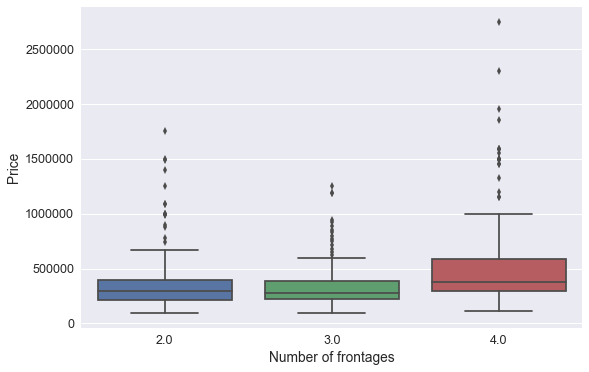

In [88]:
sns.boxplot(x=df2['Number of frontages'], y=df2['Price'])
plt.show()

In [89]:
df2.groupby('Number of frontages')['Price'].median()

Number of frontages
2.0    295000.0
3.0    276500.0
4.0    374000.0
Name: Price, dtype: float64

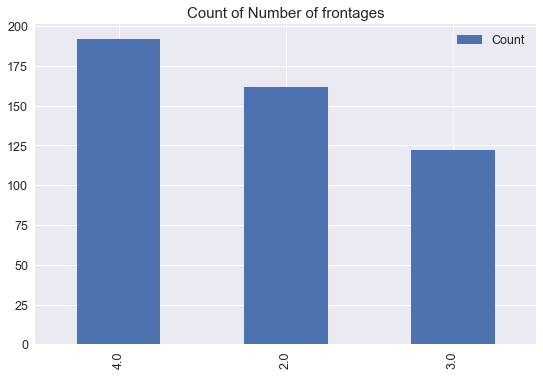

In [90]:
display_count(df2,'Number of frontages')

The repartition of observations between 2,3 and 4 frontages is quite good. We can see the median is significantly higher for 4 frontages houses, while it is similar for 2 and 3 frontages houses. 
<br><b>But are 4-frontages houses bigger than 2 and 3 frontages ones ?</b>

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


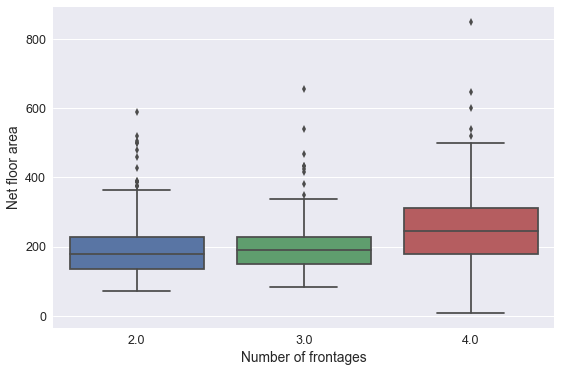

In [91]:
sns.boxplot(x=df2['Number of frontages'], y=df2['Net floor area'])
plt.show()

The tendancy is very similar to what has been observed with price. 4-frontages houses are often more expensive than 2 and 3 frontages ones !
<br>As we do not have many observations for really expensive houses, we'll drop all prices above 2e6€ !

In [92]:
df2 = df2.drop(df2[df2['Price']>2000000].index).reset_index(drop=True)

#### Now, what about the expert's dataframe ?
With the expert dataframe, we dropped a few features such as cadastral income, building condition or year of construction. For the main part, features are otherwise the same. But we decided to keep the indoor parking spaces. Can we justify this choice through a visualization ?

<br>
First, let's remove outliers the way we did with the other dataframe:

In [93]:
df2_e = df2_e.drop(df2_e[df2_e['Price']>2000000].index).reset_index(drop=True)
df2_e = df2_e.drop(df2_e[(df2_e['Net floor area']>600) & (df2_e['Price']<1000000)].index).reset_index(drop=True)
df2_e = df2_e.drop(df2_e[(df2_e['Bedrooms']>=9)].index).reset_index(drop=True)

<b>Do we get the same features (roughly) when looking at the correlation with price ?</b>

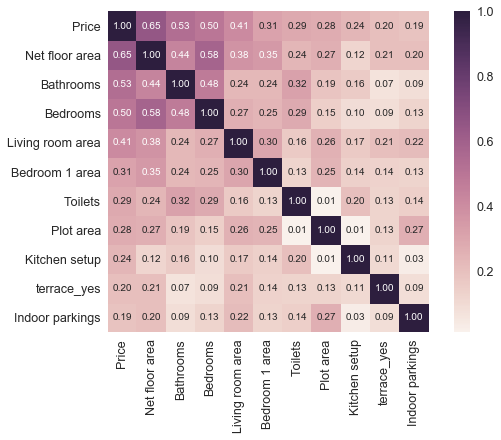

In [94]:
#For the expert's dataframe
display_heatmap(df2_e,'Price')

Yes ! Except that we previously had cadastral income. Also, we had a better correlation with "Toilets". But as discussed earlier, it makes no sense to highly correlate the number of toilets with the price as nobody will pay twice the price for a house if we place twice the amount of toilets in it. <br>
<b>Do the indoor parking spaces influence price positively ?</b>

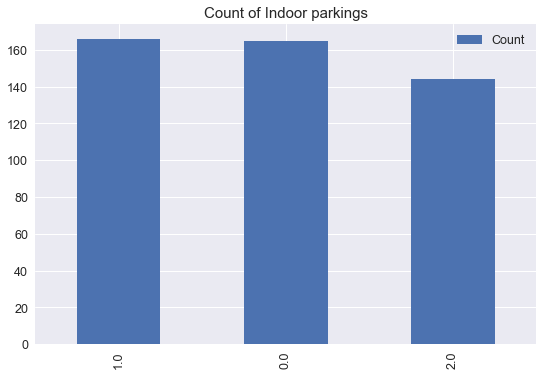

In [95]:
display_count(df2_e,'Indoor parkings')

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


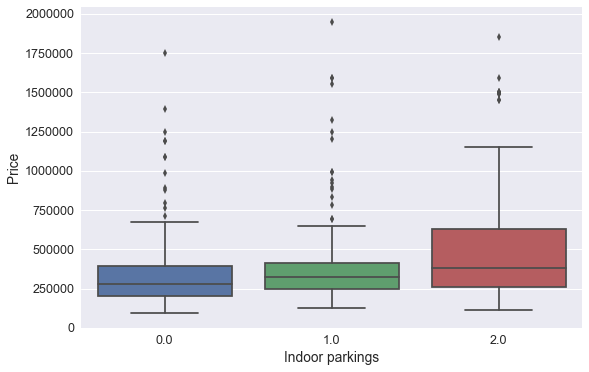

In [96]:
sns.boxplot(x=df2_e['Indoor parkings'],y=df2_e['Price'])
plt.show()

In [97]:
df2_e.groupby('Indoor parkings')['Price'].median()

Indoor parkings
0.0    279000.0
1.0    324500.0
2.0    380000.0
Name: Price, dtype: float64

Based on the above, we can say that having indoor parking spaces is clearly a value-adder. The median price if you have 2 is at 380k€, while it is at 279k€ when you have none !
<br>
Now that we have dealt with some outliers and understood our data, let's make sure we have similar dataframes (representing the same observations) before going further.

In [98]:
print('The initial dataframe has {0:1d} observations, while the expert\'s dataframe has {1:1d}'.format(len(df2),len(df2_e)))


The initial dataframe has 474 observations, while the expert's dataframe has 475


In [99]:
df2['Price'].describe()

count    4.740000e+02
mean     4.166693e+05
std      3.084926e+05
min      9.300000e+04
25%      2.390000e+05
50%      3.200000e+05
75%      4.597500e+05
max      1.950000e+06
Name: Price, dtype: float64

In [100]:
df2_e['Price'].describe()

count    4.750000e+02
mean     4.178868e+05
std      3.093073e+05
min      9.300000e+04
25%      2.390000e+05
50%      3.200000e+05
75%      4.625000e+05
max      1.950000e+06
Name: Price, dtype: float64

Both dataframes have approximately the same observations (although we filtered slightly differently). 

## INFERENTIAL STATISTICS

Let's confirm with a statistically sound analysis that the price and the Indoor parking spaces are correlated. If not, we'll remove them from the analysis performed with the expert's dataframe !

Here are our hypothesis:<br>
H0 = Price and Indoor Parkings are correlated<br>
H1 = Price and Indoor Parkings are not correlated <br>

Let's first create a dataframe containing only these features:

In [101]:
stats1 = pd.DataFrame({'Price':df2_e['Price'],'Indoor parkings':df2_e['Indoor parkings']})
stats1 = stats1.reset_index(drop=True)
stats1.head()

,Indoor parkings,Price
0,2.0,299000.0
1,1.0,239000.0
2,2.0,1590000.0
3,1.0,350000.0
4,0.0,195000.0


In [102]:
cor1 = stats1.corr()
print('Correlation between Price and number of indoor parkings is : ',cor1.iloc[0][1])

Correlation between Price and number of indoor parkings is :  0.193124531156


Light positive trend, meaning that number of indoor parking seems to slightly follow the increase of price.<br>
Let's look at the <b>p-value</b>. By looking at the p-value, we want to see the probability of having such a correlation (0.19) if the variables were unrelated. If it is really low, the null hypothesis (H0) can be rejected (= if really really low probability of seeing this correlation even if variables are unrelated, then the correlation is not significant). 
I'll use Pearson's correlation coefficient and associated p-value:

In [103]:
import scipy
from decimal import Decimal

pearson_coeff,p_value = scipy.stats.pearsonr(stats1['Price'],stats1['Indoor parkings'])
print('Pearson coefficient of correlation is {:1.6f}, whit a p-value of'.format(pearson_coeff),'%.2E' % Decimal(p_value))

Pearson coefficient of correlation is 0.193125, whit a p-value of 2.26E-05


We observe a really low p-value, way below 0.05 ! It means that there is a very <b>very low probability of seeing this correlation with un-related variables. So we can keep indoor parkings in our analysis.</b> <br>
It is perfectly in line with partical significance (as mentioned by the expert).<br><br>
<b>Let's do the same with Net Floor Area:</b>

In [104]:
stats2 = pd.DataFrame({'Price':df2_e['Price'],'Net floor area':df2_e['Net floor area']})
stats2 = stats2.reset_index(drop=True)
stats2.head()

,Net floor area,Price
0,250.0,299000.0
1,338.0,239000.0
2,335.0,1590000.0
3,189.0,350000.0
4,120.0,195000.0


In [105]:
cor2 = stats2.corr()
print('Correlation between Price and net floor area is : ',cor2.iloc[0][1])
pearson_coeff2,p_value2 = scipy.stats.pearsonr(stats2['Price'],stats2['Net floor area'])
print('Pearson coefficient of correlation is {:1.6f}, whit a p-value of'.format(pearson_coeff2),'%.2E' % Decimal(p_value2))

Correlation between Price and net floor area is :  0.652358016434
Pearson coefficient of correlation is 0.652358, whit a p-value of 6.43E-59


As we could see on the correlation matrix, we have a clear correlation, which is highly significant (very low p-value).
<br> <b>Is there a significant difference of median price between "as new" houses and the others ?</b><br>
H0 = Median price is not different between "As New" houses and the others<br>
H1 = Median price is significantly different between "As New" houses and the others <br>

In [106]:
as_new = df2[df2['condition_As new']==1]['Price']
not_new = df2[df2['condition_As new']==0]['Price']

#Testing null hypothesis that median price is the same for "As New" and the others:
from statsmodels.stats.weightstats import ztest

z_score, pValue_z = ztest(x1= as_new, x2=not_new, value=0, alternative='two-sided', usevar='pooled', ddof=1)
print('z_score is {:1.8f}, p-value is {:1.8f}'.format(z_score,pValue_z))

z_score is 9.87999752, p-value is 0.00000000


It looks like "As New" houses are priced higher than the other ones, and the low p-value indicates that we can reject the null hypothesis, meaning that we have a significantly different price !

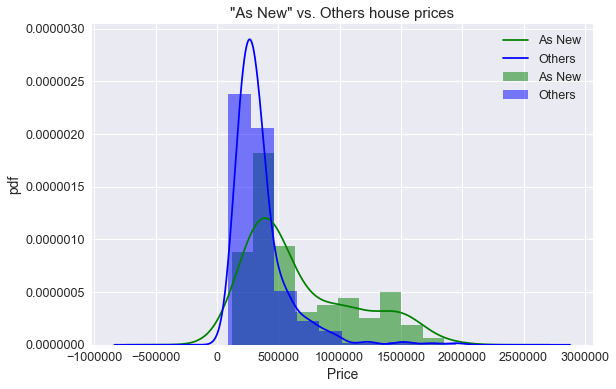

In [107]:
as_new.plot(kind='hist', bins=10, color = 'green', normed= True,label= 'As New', alpha = 0.5)
as_new.plot(kind='kde',color = 'green', label= 'As New' )
not_new.plot(kind='hist', bins=10, color = 'blue', normed= True, label= 'Others',alpha = 0.5)
not_new.plot(kind='kde',color = 'blue',label = 'Others')
plt.legend(loc='upper right')
plt.title('"As New" vs. Others house prices')
plt.xlabel('Price')
plt.ylabel('pdf')
plt.show()

 Let's now try to have a better understanding of the Price feature, our target here:<br>
How do we comply with CLT requirements ? We have here a large sample (>30), and the variables are obviously independant (prices are not linked to each other). But as we saw earlier, Price is not normally distributed. Let's confirm this with the ECDF.

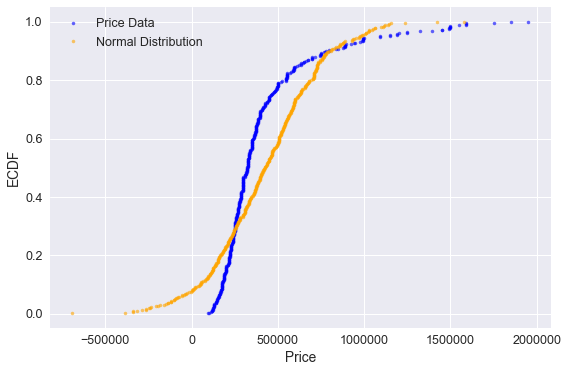

In [108]:
#ecdf function
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1,1+n) / n

    return x, y

#Let's plot ECDF of our data and of normally distributed data
central = np.random.normal(np.mean(stats1['Price']),np.std(stats1['Price']),len(stats1['Price']))

x_price,y_price=ecdf(stats1.Price)
x_central,y_central=ecdf(central)

_=plt.plot(x_price,y_price,marker='.',linestyle='none',color='blue',alpha=0.6)
_=plt.plot(x_central,y_central,marker='.',linestyle='none',color='orange',alpha=0.6)
_=plt.xlabel('Price')
_=plt.ylabel('ECDF')
_=plt.legend(('Price Data','Normal Distribution'))
plt.show()

Clearly, we do not have a normal distribution ! Let's try making it closer to a normal distribution, and remove some more outliers.

In [109]:
#Let's do another backup of our dataframes at this point.
df3 = df2.copy()
df3_e = df2_e.copy()


 mu = 12.75 and sigma = 0.57



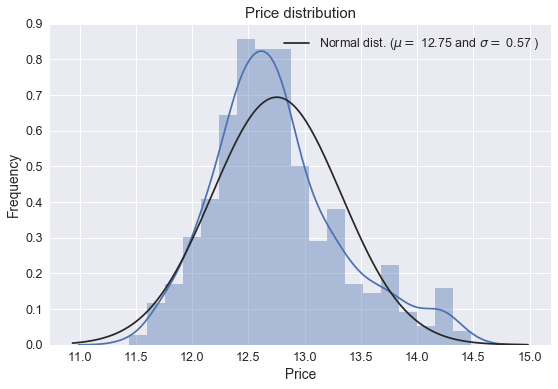

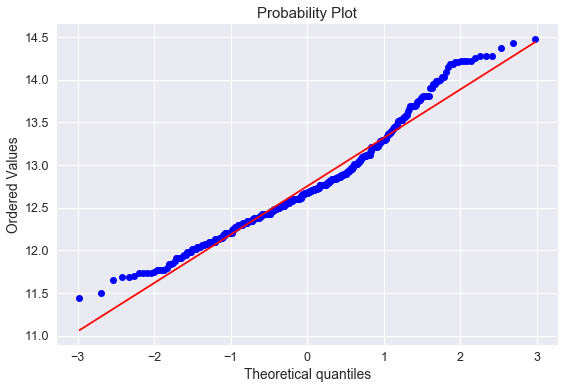

Skewness: 0.692043
Kurtosis: 0.384232


In [110]:
# log1p to apply log(1+x) to Price --> Making price normally distributed.
df3['Price'] = np.log1p(df3['Price'])

#Check the new distribution 
sns.distplot(df3['Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df3['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(df3['Price'], plot=plt)
plt.show()

print("Skewness: %f" % df3['Price'].skew())
print("Kurtosis: %f" % df3['Price'].kurt())

Data is now closer to the normal distribution. But still, we observe a positive skewness ! Let's keep the 95.4% of data closer to the median:

In [111]:
print('Initial amount of observations is {0:1d}'.format(len(df3)))
df3_mean = np.mean(df3['Price'])
df3_sd = np.std(df3['Price'])
df3 = df3[df3['Price']> df3_mean-2*df3_sd ]
df3 = df3[df3['Price']< df3_mean+2*df3_sd ]
print('Final amount of observations is {0:1d}'.format(len(df3)))

Initial amount of observations is 474
Final amount of observations is 448


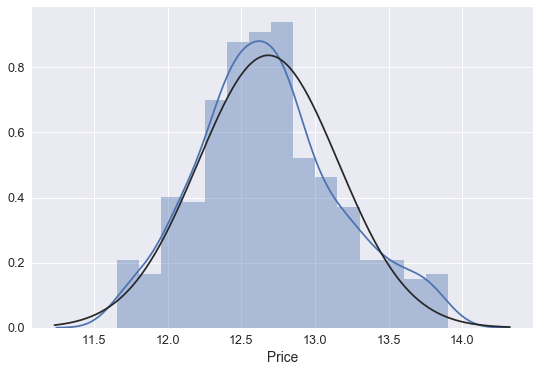

Skewness: 0.340087
Kurtosis: -0.166375


In [112]:
sns.distplot(df3['Price'] , fit=norm)
plt.show()
print("Skewness: %f" % df3['Price'].skew())
print("Kurtosis: %f" % df3['Price'].kurt())

It's already way better. Let's apply the same technique to the expert's dataframe.


 mu = 12.75 and sigma = 0.58



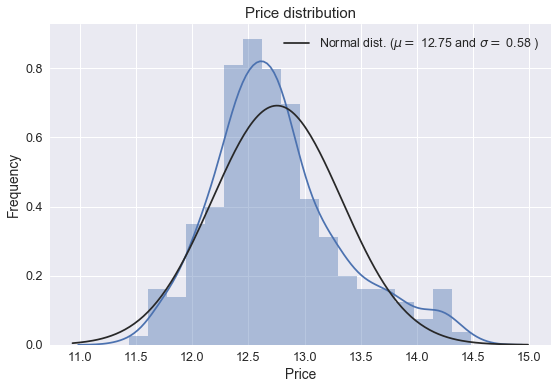

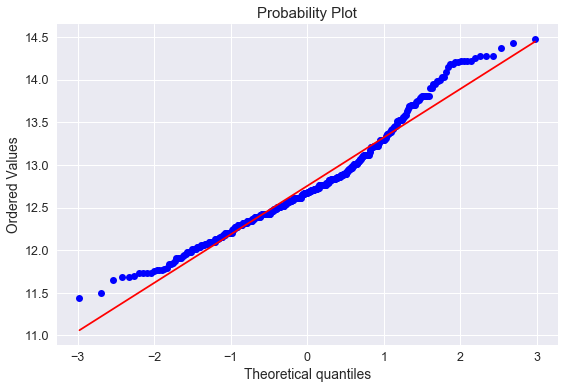

Skewness: 0.686857
Kurtosis: 0.356633


In [113]:
# log1p to apply log(1+x) to Price --> Making price normally distributed.
df3_e['Price'] = np.log1p(df3_e['Price'])

#Check the new distribution 
sns.distplot(df3_e['Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df3_e['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(df3_e['Price'], plot=plt)
plt.show()

print("Skewness: %f" % df3_e['Price'].skew())
print("Kurtosis: %f" % df3_e['Price'].kurt())

In [114]:
print('Initial amount of observations is {0:1d}'.format(len(df3_e)))
df3_e_mean = np.mean(df3_e['Price'])
df3_e_sd = np.std(df3_e['Price'])
df3_e = df3_e[df3_e['Price']> df3_e_mean-2*df3_e_sd ]
df3_e = df3_e[df3_e['Price']< df3_e_mean+2*df3_e_sd ]
print('Final amount of observations is {0:1d}'.format(len(df3_e)))

Initial amount of observations is 475
Final amount of observations is 449


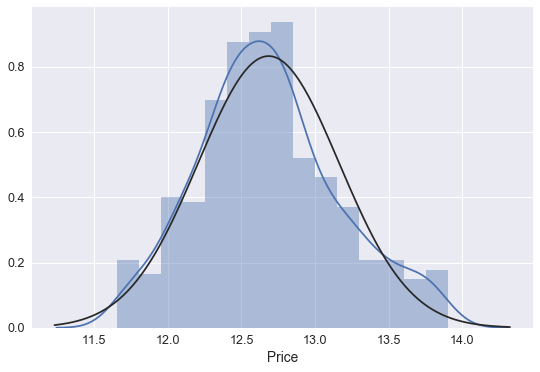

Skewness: 0.347576
Kurtosis: -0.168366


In [115]:
sns.distplot(df3_e['Price'] , fit=norm)
plt.show()
print("Skewness: %f" % df3_e['Price'].skew())
print("Kurtosis: %f" % df3_e['Price'].kurt())

Thanks to inferential statistics, we could confirm the importance of Net floor area and Indoor parkings for our model. We could also assess the distribution of our data, and try making it closer to normal (+ remove a few more potential outliers, so that we keep a coherent spread). In the next steps, we'll look at the other features and evaluate wether we need the same transformation or not.
<br>
## MACHINE LEARNING
Let's have a look at different models, and try to improve them. We'll always try minimizing the root mean squared error (rmse).

In [116]:
#Copy of our dataframes
df4 = df3.copy()
df4_e = df3_e.copy()

In [117]:
#Dropping Address, not used here (not enough observations to properly map the country regarding housing prices)
df4.drop('Address', axis=1, inplace=True)

##### Let's split the data into train and test sets:
First for the initial dataframe

In [118]:
from sklearn.model_selection import train_test_split
X = df4.drop('Price', axis=1)
y = df4['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Then for the expert's dataframe:

In [119]:
from sklearn.model_selection import train_test_split
X_e = df4_e.drop('Price', axis=1)
y_e = df4_e['Price']
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.33, random_state=42)

#### Simple Linear Regression
With initial dataframe:

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.6081682020963153
Root Mean Squared Error: 0.297209364698533


In [121]:
cv_scores = cross_val_score(reg,X,y,cv=5)

print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[ 0.51887248  0.70070916  0.67452081  0.54830846  0.76043038]
Average 5-Fold CV Score: 0.6405682565326252


With the expert's dataframe:

In [122]:
reg_e = LinearRegression()
reg_e.fit(X_train_e, y_train_e)
y_pred_e = reg_e.predict(X_test_e)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_e.score(X_test_e, y_test_e)))
rmse_e = np.sqrt(mean_squared_error(y_test_e,y_pred_e))
print("Root Mean Squared Error: {}".format(rmse_e))

R^2: 0.513275707466703
Root Mean Squared Error: 0.32981369437469077


In [123]:
cv_scores_e = cross_val_score(reg_e,X_e,y_e,cv=5)

print(cv_scores_e)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_e)))

[ 0.45785997  0.60791323  0.29276345  0.34645436  0.59438257]
Average 5-Fold CV Score: 0.4598747160614357


<b>First observation:</b> with a simple linear regression, we obtain better results with the initial dataframe ! In this dataframe, we have way more features (treated differently). Also, we have cadastral income, which is highly correlated to housing price (calculated based on house's value). Let's try different models (and improving them). Once we'll have a better one, we'll try to understand why we cannot reach the same R².

#### Gradient Boosting

In [124]:
from sklearn import ensemble
#parameters: loss='ls' to optimize least squares regression
#learning rate= 0.1(default)
#n_estimators is the number of boosting stages--> can be high because gradient boosting is not sensitive to over-fitting
#max_depth limits number of nodes in the tree (to be fine-tuned)
# min_samples_split --> 2 , so 2 samples needed to split a node.

GB = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, \
                                         min_samples_split = 2, learning_rate = 0.1, loss='ls')

GB.fit(X_train,y_train)
cv_score = cross_val_score(GB, X, y, cv=5)
print(cv_score)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_score)))

[ 0.58834813  0.6757799   0.70684678  0.66642204  0.75388008]
Average 5-Fold CV Score: 0.6782553880102566


In [125]:
y_pred = GB.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.2786084151809043


This model is better than the linear regression as we could improve R² and reduce the rmse.
What does the same model give with our expert's dataframe ?

In [126]:
GB_e = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, \
                                         min_samples_split = 2, learning_rate = 0.1, loss='ls')

GB_e.fit(X_train_e,y_train_e)
cv_score_e = cross_val_score(GB_e, X_e, y_e, cv=5)
print(cv_score_e)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_score_e)))

y_pred_e = GB_e.predict(X_test_e)
rmse_e = np.sqrt(mean_squared_error(y_test_e,y_pred_e))
print("Root Mean Squared Error: {}".format(rmse_e))

[ 0.43897985  0.53656063  0.1990562   0.32145831  0.47938295]
Average 5-Fold CV Score: 0.3950875920160177
Root Mean Squared Error: 0.3669488866927712


There is as well an improvement, but it's still worse than when using the initial dataframe ! <br>
Let's have a look at our numeric features. If there is skewness, we may be able to correct this with a box-cox transform.
##### Data transformation

In [127]:
numeric_feats = df4.dtypes[df4.dtypes == 'float64'].index
numeric_feats = numeric_feats.drop('Price')
from scipy.stats import skew

# Check the skew of all numerical features
skewed_feats = df4[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness

,Skewed Features
Plot area,5.697999
Cadastral income,2.836134
Living room area,2.483937
Bedroom 1 area,1.991932
Bathrooms,1.962077
EPC - Energy consumption,1.936287
Net floor area,1.055454
Bedrooms,0.995010
Toilets,0.941579
Number of frontages,-0.076936


Let's transform the features for which skewness is above 0.75 (arbitrarily).<br>
<b>Box-Cox transformation:</b>
Box-Cox transformation enables us to transform a distribution from non-normal to normal. Let's apply this transformation on skewed features:
(see: http://www.statisticshowto.com/box-cox-transformation/)

There are 10 skewed numerical features to Box Cox transform


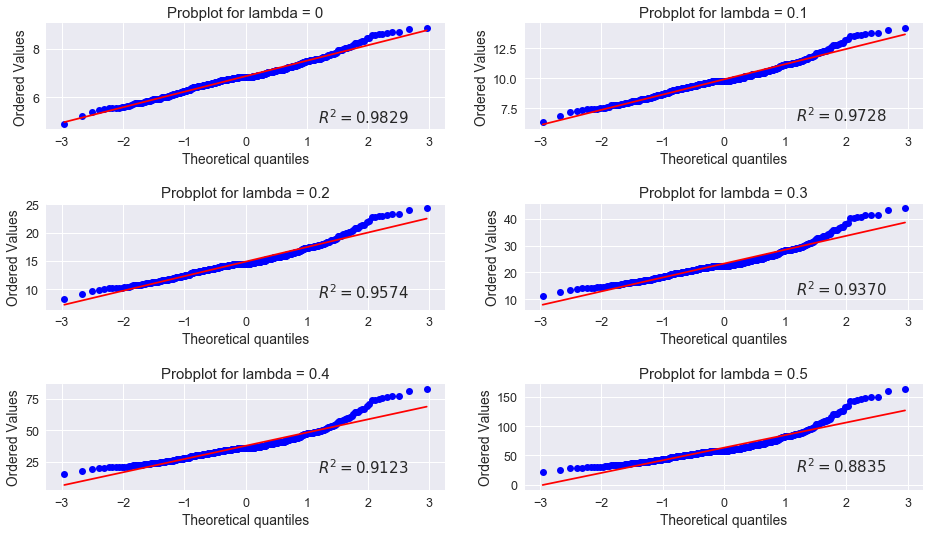

In [128]:
skewness = skewness[abs(skewness['Skewed Features']) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p #--> log(1+x) if lambda = 0. What's the best value of lambda ?

#Let's try to find a good lambda value for one feature, then use it for all features. 
#I'll work with cadastral income as it is highly correlated to price.


fig, axs = plt.subplots(3,2,figsize=(14, 8))
fig.subplots_adjust(hspace = .7, wspace=0.2)
axs = axs.ravel()
stats.probplot(boxcox1p(df4['Cadastral income'], 0), plot=axs[0],rvalue=True) 
axs[0].set_title('Probplot for lambda = 0')
cpt=1
for l in np.arange(0.1,0.6,0.1):
    res = stats.probplot(boxcox1p(df4['Cadastral income'], l), plot=axs[cpt],rvalue=True)
    axs[cpt].set_title('Probplot for lambda = '+str(l))
    cpt+=1
    
plt.show()

It looks like 0 is the best parameter for our transformation. Let's use this for all skewed features.

In [129]:
skewed_features = skewness.index
lam = 0
for feat in skewed_features:
    df4[feat] = boxcox1p(df4[feat], lam)
    df4[feat] += 1

In [130]:
skewed_feats = df4[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness

,Skewed Features
Bathrooms,1.538029
Bedroom 1 area,0.486310
Cadastral income,0.316219
Bedrooms,0.259020
Toilets,0.127555
Number of frontages,-0.076936
EPC - Energy consumption,-0.099406
Plot area,-0.262958
Living room area,-0.393248
Net floor area,-0.804175


Globally, it looks better. Although we see that "Year of construction" is slightly more skewed than before.<br>
Could we improve GradientBoosting with this ? Let's try:

In [131]:
X = df4.drop('Price', axis=1)
y = df4['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

GB = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, \
                                         min_samples_split = 2, learning_rate = 0.1, loss='ls')

GB.fit(X_train,y_train)
cv_score = cross_val_score(GB, X, y, cv=5)
print(cv_score)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_score)))

y_pred = GB.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

[ 0.5817788   0.67226031  0.70949289  0.65764889  0.75926924]
Average 5-Fold CV Score: 0.6760900233574552
Root Mean Squared Error: 0.278925136950197


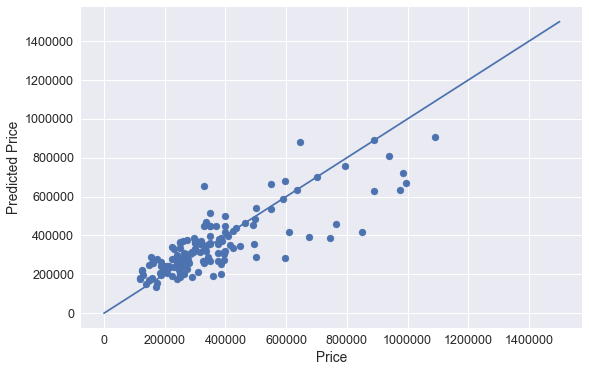

In [132]:
#Price had been normalized with log1p. Now we need to go back to euros:
price_test = np.expm1(y_test)
price_predict = np.expm1(y_pred)
plt.scatter(price_test,price_predict)
plt.xlabel('Price')
plt.ylabel('Predicted Price')
plt.plot(range(1500000))
plt.show()

As we can observe on the chart above, predicted prices are further from the line (actual price) for more expensive houses. Also, there are not many expensive houses left. Let's try getting rid of houses priced above 500k€ and see what we get:

In [133]:
df5 = df4.copy()
#Getting back to prices in EUR (previously transformed with a log(1+n))
df5.Price = np.expm1(df4.Price)
df5 = df5[df5.Price <= 500000]
df5.Price = np.log1p(df5.Price)

X = df5.drop('Price', axis=1)
y = df5['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

GB = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, \
                                         min_samples_split = 2, learning_rate = 0.1, loss='ls')

GB.fit(X_train,y_train)
cv_score = cross_val_score(GB, X, y, cv=5)
print(cv_score)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_score)))

y_pred = GB.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

[ 0.3568042   0.48084273  0.53803794  0.53671194  0.65755024]
Average 5-Fold CV Score: 0.5139894098730525
Root Mean Squared Error: 0.24185118682536802


It does not seem to be of any help. We'll keep working with df4 and prices above 500k€.<br>
<b>Using a scaler and GradientBoosting:</b>

In [134]:
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

X = df4.drop('Price', axis=1)
y = df4['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaled_GB = make_pipeline(StandardScaler(), ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, \
                                         min_samples_split = 2, learning_rate = 0.1, loss='ls'))
cv_score = cross_val_score(scaled_GB,X,y,cv=5)

print(cv_score)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_score)))

scaled_GB.fit(X_train,y_train)
y_pred = scaled_GB.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

[ 0.55625132  0.678968    0.70687002  0.65339113  0.76397319]
Average 5-Fold CV Score: 0.6718907333882409
Root Mean Squared Error: 0.27685758760991147


StandardScaler, Normalizer and RobustScaler have been used. StandardScaler yields the best results, yet below what we obtained without scaling. Maybe we should try working more on our model's parameters. Scikit offers the possibility to use a generator fine-tune our model based on different test folds (cross-validation). Also, the gridsearch_cv function can help us to evaluate the model with every split and output the best set of parameters for optimal results.
We'll build a function for this.

In [135]:
from sklearn.model_selection import ShuffleSplit
from sklearn.grid_search import GridSearchCV

def GB_func(parameters, it):

    estimator = ensemble.GradientBoostingRegressor()
    
    cv=5
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters, n_jobs=it)

#Fitting the training dataset to this classifier
    classifier.fit(X_train, y_train)

#Best estimator found by GridSearchCV
    print("GridSearch's best output: ",classifier.best_estimator_)
    
    return cv, classifier.best_estimator_

C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


To evaluate models, we'll also use a plot for which the code is given by sckikit-learn. It's called "plot_learning_curve:

http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [136]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [137]:
parameters={'n_estimators':[100,200,300], 
            'learning_rate': [0.1], 
            'max_depth':[4,5,6], 
            'min_samples_leaf':[2,3], 
            'max_features':[1] 
           } 
it=4 

#Let's fit GBRT to the digits training dataset by calling the function we just created. 
cv_split,best_est=GB_func(parameters, it)

GridSearch's best output:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=1,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=3, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


The best parameters identified are the following:

In [138]:
print("Best Estimator Parameters")
print("---------------------------") 
print("n_estimators: ",best_est.n_estimators)
print("max_depth: ",best_est.max_depth) 
print("Learning Rate: ",best_est.learning_rate)
print("min_samples_leaf:", best_est.min_samples_leaf)
print("max_features: ", best_est.max_features)
print("Train R²: ",best_est.score(X_train,y_train))

Best Estimator Parameters
---------------------------
n_estimators:  300
max_depth:  6
Learning Rate:  0.1
min_samples_leaf: 3
max_features:  1
Train R²:  0.993728025863


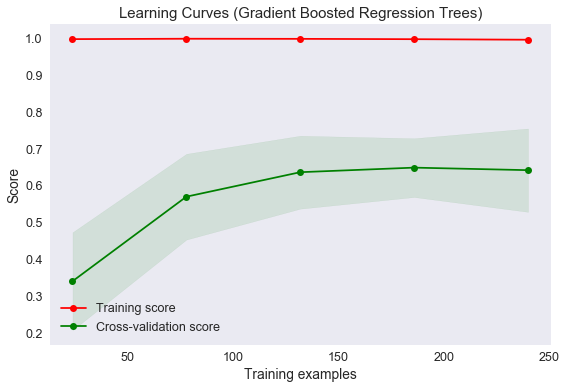

In [139]:
title = "Learning Curves (Gradient Boosted Regression Trees)" 
estimator = ensemble.GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth, 
                                      learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf, 
                                      max_features=best_est.max_features) 
plot_learning_curve(estimator, title, X_train, y_train, cv=cv_split, n_jobs=it) 
plt.show()

In [140]:
print("Train score (R²): ",best_est.score(X_train,y_train))
print("Test score (R²): ",best_est.score(X_test,y_test))

Train score (R²):  0.993728025863
Test score (R²):  0.631931993759


Maybe Gradient Boosting is not the best fit for our data. As we can see, the cross-validation score is way below the train score ! Let's try a lasso regression (+scaler).

In [141]:
from sklearn.linear_model import Lasso

def lasso_func(parameters, it):

    estimator = Lasso()
    cv=5
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters, n_jobs=it)

#Fitting the training dataset to this classifier
    classifier.fit(X_train_s, y_train_s)

#Best estimator found by GridSearchCV
    print("GridSearch's best output: ",classifier.best_estimator_)
    
    return cv, classifier.best_estimator_

In [142]:
df_scaled = df4.copy()
scaler = StandardScaler()
scaler.fit(df_scaled)
X_scl = df_scaled.drop('Price', axis=1)
y_scl = df_scaled['Price']
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_scl, y_scl, test_size=0.33, random_state=42)

In [143]:
parameters={'alpha':[0.0,0.2,0.4,0.6,0.8,1.0]
           } 
it=4 

#Let's fit GBRT to the digits training dataset by calling the function we just created. 
cv_split,best_est=lasso_func(parameters, it)

GridSearch's best output:  Lasso(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:619: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  best_estimator.fit(X, y, **self.fit_params)
C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\gmignot\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [144]:
print("Train score (R²): ",best_est.score(X_train_s,y_train_s))
print("Test score (R²): ",best_est.score(X_test_s,y_test_s))

Train score (R²):  0.755650031189
Test score (R²):  0.644529775436


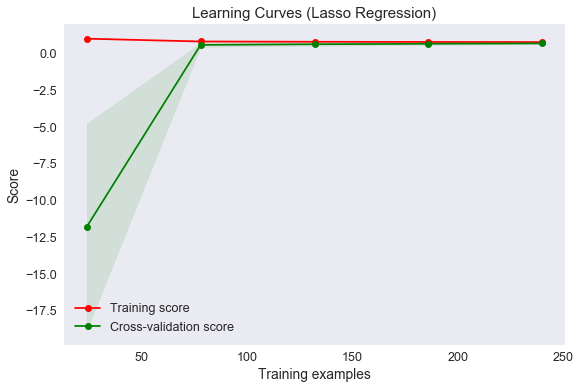

In [145]:
title = "Learning Curves (Lasso Regression)" 
estimator = Lasso(alpha=best_est.alpha) 
plot_learning_curve(estimator, title, X_train_s, y_train_s, cv=cv_split, n_jobs=it) 
plt.show()

Gradient Boosting seems to be better than Lasso here ! Let's have a look at a plot containing price and predicted price:

In [146]:
parameters={'n_estimators':[100,200,300], 
            'learning_rate': [0.1], 
            'max_depth':[4,5,6], 
            'min_samples_leaf':[2,3], 
            'max_features':[1] 
           } 
it=4 

#Let's fit GBRT to the digits training dataset by calling the function we just created. 
cv_split,best_est=GB_func(parameters, it)

GridSearch's best output:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=1,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=3, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


Root Mean Squared Error: 0.2732991411101262


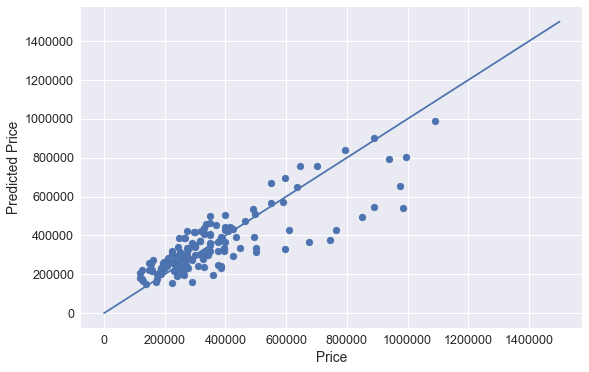

In [147]:
best_est.fit(X_train,y_train)
y_pred=best_est.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

#Price had been normalized with log1p. Now we need to go back to euros:
price_test = np.expm1(y_test)
price_predict = np.expm1(y_pred)
plt.scatter(price_test,price_predict)
plt.xlabel('Price')
plt.ylabel('Predicted Price')
plt.plot(range(1500000))
plt.show()

Let's try some feature selection and see whether we can improve our model:

In [148]:
from sklearn.feature_selection import RFE
model = best_est
rfe = RFE(model, 25) #keeping the 20 most important features
fit = rfe.fit(X, y)
print("Num Features: ",fit.n_features_)
print("Selected Features: ",fit.support_)
print("Feature Ranking: ",fit.ranking_)

Num Features:  25
Selected Features:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True False  True  True  True False False False
 False False  True  True False False  True  True False  True  True]
Feature Ranking:  [ 1  1  1  1  1  1  1  1  1  1  1  1  1  5  1  1  1  4  1  1  1  6  7 11  3
  8  1  1  9 10  1  1  2  1  1]


In [149]:
from itertools import compress
f_to_keep = list(compress(list(df4.columns),fit.support_))
f_to_keep

['Bathrooms',
 'Bedroom 1 area',
 'Bedrooms',
 'Cadastral income',
 'EPC - Energy consumption',
 'Net floor area',
 'Number of frontages',
 'Plot area',
 'Toilets',
 'Year of construction',
 'Living room area',
 'Price',
 'condition_As new',
 'condition_Just renovated',
 'condition_To be done up',
 'condition_To be renovated',
 'double_glazing_yes',
 'kitchen_Hyper-equipped',
 'kitchen_Installed',
 'heating_Electric',
 'heating_Fuel',
 'heating_Wood',
 'terrace_no',
 'elec_report_no',
 'elec_report_yes, conform']

GridSearch's best output:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=1,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=2, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
Root Mean Squared Error: 0.2901672601529472
Train score (R²):  0.944382315368
Test score (R²):  0.626516417322


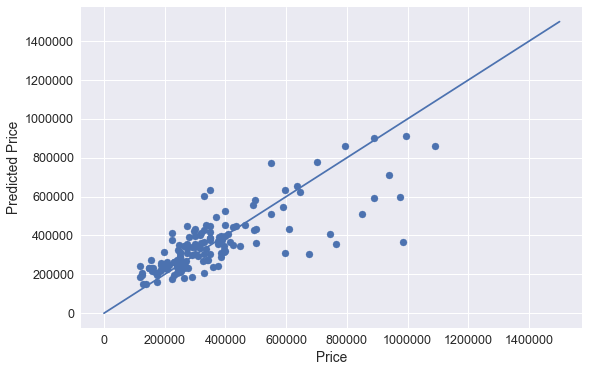

In [150]:
df_ft = df4[f_to_keep]
X = df_ft.drop('Price', axis=1)
y = df_ft['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

parameters={'n_estimators':[100,200,300], 
            'learning_rate': [0.1], 
            'max_depth':[4,5,6], 
            'min_samples_leaf':[2,3], 
            'max_features':[1] 
           } 
it=4 

#Let's fit GBRT to the digits training dataset by calling the function we just created. 
cv_split,best_est=GB_func(parameters, it)

best_est.fit(X_train,y_train)
y_pred=best_est.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Train score (R²): ",best_est.score(X_train,y_train))
print("Test score (R²): ",best_est.score(X_test,y_test))

#Price had been normalized with log1p. Now we need to go back to euros:
price_test = np.expm1(y_test)
price_predict = np.expm1(y_pred)
plt.scatter(price_test,price_predict)
plt.xlabel('Price')
plt.ylabel('Predicted Price')
plt.plot(range(1500000))
plt.show()

Feature Selection did not help improving our model here !
#### Intermediate conclusion:
The best model is Scaler + Gradient Boosting Regressor. It yiels an R² = 0.671<br>
I'v not been able to improve this score. Let's now look what we can get out of the expert's dataframe. As we saw previously, we may not be able to do better (too few features ?). <br>
#### Ridge Regression:

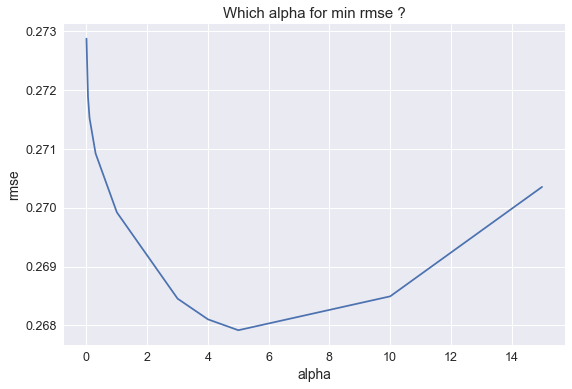

In [151]:
from sklearn.linear_model import Ridge

#Function to obtain rmse from crossval
def rmse_cv(model,x,y):
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

alpha_test = [0.0,0.05, 0.1, 0.3, 1, 3,4, 5, 10, 15]
cv_ridge = [rmse_cv(Ridge(alpha = x),X_train,y_train).mean() for x in alpha_test]
cv_ridge = pd.Series(cv_ridge, index = alpha_test)
cv_ridge.plot(title = "Which alpha for min rmse ?")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

It looks like an alpha of 5 yields the smaller rmse ! We'll compute this rmse to compare it to what we obtained from previous models:

In [152]:
cv_ridge.min()

0.26791899448280487

It's the best score we obtained yet (on the whole price range) ! Let's have a look at the residuals:

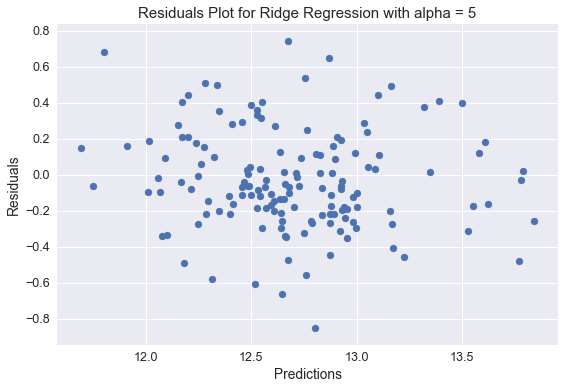

In [153]:
model_ridge = Ridge(alpha=5)
model_ridge.fit(X_train,y_train)
y_pred_ridge = model_ridge.predict(X_test)
residuals = y_test - y_pred_ridge
plt.scatter(y_pred_ridge,residuals)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Ridge Regression with alpha = 5')
plt.show()

Residuals are randomly dispersed around the horizontal axis, meaning that a linear model is appropriate for our data !<br>
We'll now try a last improvement, by using an <b>xgboost</b> model:

In [154]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)
params = {"max_depth":2, "eta":0.1}
xgb_rmse = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [155]:
xgb_rmse.head()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,10.988888,0.028542,10.988913,0.012255
1,9.897638,0.029762,9.897666,0.011048
2,8.915209,0.030861,8.915241,0.009962
3,8.030801,0.031850,8.030836,0.008986
4,7.234687,0.032741,7.234726,0.008108


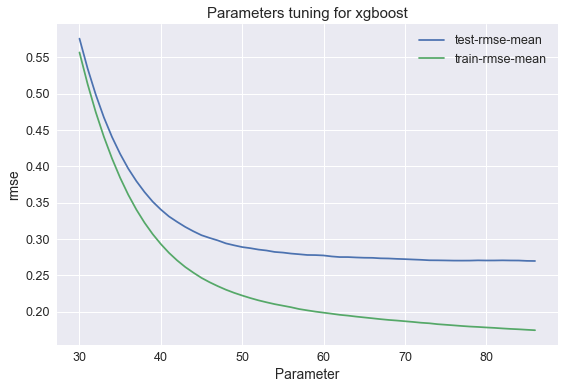

In [156]:
xgb_rmse.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.xlabel('Parameter')
plt.ylabel('rmse')
plt.title('Parameters tuning for xgboost')
plt.show()

Let's use n_estimators = 110 :

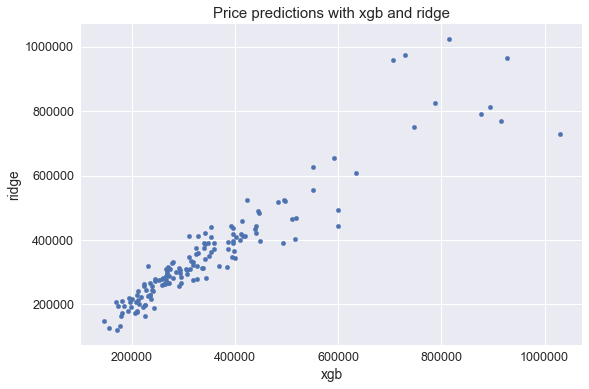

In [157]:
model_xgb = xgb.XGBRegressor(n_estimators=110, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_test)
ridge_preds = model_ridge.predict(X_test)
predictions = pd.DataFrame({"xgb":np.expm1(xgb_preds), "ridge":np.expm1(ridge_preds)})
predictions.plot(x = "xgb", y = "ridge", kind = "scatter")
plt.title('Price predictions with xgb and ridge')
plt.show()

Let's try an average of these models:

In [ ]:
predictions = 0.5*np.expm1(ridge_preds) + 0.5*np.expm1(xgb_preds)

In [ ]:
plt.scatter(np.expm1(y_test),predictions,label='Avg',color='red')
plt.scatter(np.expm1(y_test),np.expm1(ridge_preds),label='Ridge',color='green',alpha=0.3)
plt.scatter(np.expm1(y_test),np.expm1(xgb_preds),label='XGBoost',color='blue',alpha=0.3)
plt.plot(range(1000000))
plt.xlabel('Actual Annonced Price')
plt.ylabel('Predicted Price')
plt.title('Averaged prediction (xgb and ridge) vs real price')
plt.legend(loc='upper left')
plt.show()

Residuals for the above:

In [ ]:
residuals_avg = y_test - np.log1p(predictions)
residuals_ridge = y_test - ridge_preds
residuals_xgboost = y_test - xgb_preds

plt.scatter(np.log1p(predictions),residuals_avg,label='Avg',color='red')
plt.scatter(ridge_preds,residuals_ridge,label='Ridge',color='green',alpha=0.3)
plt.scatter(xgb_preds,residuals_xgboost,label='XGBoost',color='blue',alpha=0.3)
plt.xlabel('Predictions (log1p)')
plt.ylabel('Residuals')
plt.title('Residuals plot for xgb and ridge and average of both')
plt.legend(loc='upper left')
plt.show()

The obtained model is not really good. It can be partly explained by the fact that we don't have many observations. After filtering and cleaning, there are even less. And since we even split train and test sets, it's worse. Just to see if it has an impact, let's try reducing the test set size and increase the training set (we'll do this only with ridge).

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.15, random_state=42)
model_ridge_1 = Ridge(alpha=5) 
model_ridge_1.fit(X_train_1,y_train_1)
ridge_preds_1 = np.expm1(model_ridge_1.predict(X_test_1))

plt.scatter(np.expm1(y_test),np.expm1(ridge_preds),label='Smaller train',color='green',alpha=0.6)
plt.scatter(np.expm1(y_test_1),ridge_preds_1,label='Bigger train',color='blue',alpha=0.6)
plt.plot(range(1000000))
plt.xlabel('Actual Annonced Price')
plt.ylabel('Predicted Price')
plt.title('Predictions comparison with smaller and bigger training sets')
plt.legend(loc='upper left')
plt.show()

#rmse on transformed price !(not on price !!!)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_ridge))
rmse_1 = np.sqrt(mean_squared_error(y_test_1,model_ridge_1.predict(X_test_1)))
print("Smaller Training Set - Root Mean Squared Error: {}".format(rmse))
print("Bigger Training Set - Root Mean Squared Error: {}".format(rmse_1))

It confirms our previous expecation that increasing the number of observations greatly helps for training ! Though since we increased the amount of observations in the training set, we decreased the amount of observations for which we want to predict the target in the test set.

#### Can we get better results with the expert's dataframe ?
It's important to note that we have less features in this dataframe. Also, we already observed way worse results with this dataframe than with the initial one, when using linear models.
##### Data transformation

In [ ]:
numeric_feats_e = df4_e.dtypes[df4_e.dtypes == 'float64'].index
numeric_feats_e = numeric_feats_e.drop('Price')

# Check the skew of all numerical features
skewed_feats_e = df4_e[numeric_feats_e].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness_e = pd.DataFrame({'Skewed Features' :skewed_feats_e})
skewness_e

In [ ]:
#NET FLOOR AREA will be used to find the best alpha, as it is the feature with highest correlation coefficient with price.
skewness_e = skewness_e[abs(skewness_e['Skewed Features']) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness_e.shape[0]))

fig, axs = plt.subplots(3,2,figsize=(14, 8))
fig.subplots_adjust(hspace = .7, wspace=0.2)
axs = axs.ravel()
stats.probplot(boxcox1p(df4_e['Net floor area'], 0), plot=axs[0],rvalue=True) 
axs[0].set_title('Probplot for lambda = 0')
cpt=1
for l in np.arange(0.1,0.6,0.1):
    res = stats.probplot(boxcox1p(df4_e['Net floor area'], l), plot=axs[cpt],rvalue=True)
    axs[cpt].set_title('Probplot for lambda = '+str(l))
    cpt+=1
    
plt.show()

We'll use alpha = 0.3:

In [ ]:
skewed_features_e = skewness_e.index
lam = 0.3
for feat in skewed_features_e:
    df4_e[feat] = boxcox1p(df4_e[feat], lam)
    df4_e[feat] += 1

In [ ]:
skewed_feats_e = df4_e[numeric_feats_e].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness_e = pd.DataFrame({'Skewed Features' :skewed_feats_e})
skewness_e

Let's now try ridge regression:

In [ ]:
X_e = df4_e.drop('Price', axis=1)
y_e = df4_e['Price']
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.15, random_state=42)


cv_ridge_e = [rmse_cv(Ridge(alpha = x),X_train_e,y_train_e).mean() for x in alpha_test]
cv_ridge_e = pd.Series(cv_ridge_e, index = alpha_test)
cv_ridge_e.plot(title = "Which alpha for min rmse ?")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

Let's keep alpha = 10 ! We can already see, by looking at the scale, that we'll not do as good as with the initial dataframe.

In [ ]:
model_ridge_e = Ridge(alpha=10)
model_ridge_e.fit(X_train_e,y_train_e)
y_pred_ridge_e = model_ridge_e.predict(X_test_e)
residuals_e = y_test_e - y_pred_ridge_e
plt.scatter(y_pred_ridge_e,residuals_e)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Ridge Regression with alpha = 10')
plt.show()

Again, residuals are spread randomly, so we know using a linear model is fine.

## CONCLUSIONS

The idea behind this project was to emphasize the fact that a data scientist with extensive knowledge of the field he works in has better chances of obtaining good results. Unfortunately, it's not been possible to prove this point with the data used. <br>
The first criteria for housing price estimation is probably the localization. We had to drop this feature as we have too few data and therefore cannot map the influence of localization properly.
<br>
Following the real-estate professionnal's advices led to dropping a few interesting features such as cadastral income. 
This feature is quite tricky to understand. Indeed, it is obtained from the value of the house (calculated by experts from the state). The real-estate expert therefore adivsed not to take this as an input as this feature can be out-dated (cadastral income is not systematically revised). Let's have a quick look at what the ridge model would give us without this feature in the initial dataframe:

In [ ]:
X = df_ft.drop(['Price','Cadastral income'], axis=1)
y = df_ft['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
alpha_test = [0.0,0.05, 0.1, 0.3, 1, 3,4, 5, 10, 15]
cv_ridge = [rmse_cv(Ridge(alpha = x),X_train,y_train).mean() for x in alpha_test]
cv_ridge = pd.Series(cv_ridge, index = alpha_test)
cv_ridge.plot(title = "Which alpha for min rmse ?")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()
print('When dropping cadastral income, the rmse is at best ',cv_ridge.min())
print('It is not this far from the rmse obtained with same model and expert\'s dataframe, which is ',cv_ridge_e.min())

We therefore understand the high impact of cadastral income on the model. The remaining difference can be explaine by the different amount of features used.<br>

#### Another approach to the problem

Here, the problem has been considered as a regression problem. Unfortunately, it's not been possible to accurately predict the housing price. But considering the problem as a classification one could maybe help. <br>
The idea would be to split the total price range in a few sub-ranges (e.g. ranges of 30k€) and classify houses in these ranges.
For the matter, it is required to have a well balanced number of houses per price range for training.

Let's give it a try, using our initial dataframe:

In [ ]:
#First copy our dataframe
df_class = df4.copy()
df_class.Price = np.expm1(df_class.Price)
k = 30000.0
#then create the price ranges. We'll try with 20k€ ranges
range_min = np.arange(0.0,float(df_class.Price.max() + k),k)#(df_class.Price.max()%k)),k)
range_max = np.arange(range_min[1],range_min[-1]+k,k)
price_ranges_tuples = list(zip(range_min,range_max))
price_ranges = [list(elem) for elem in price_ranges_tuples]
print(price_ranges)

In [ ]:
#Let's now assign every observation to its corresponding price range, denominated by its index. It'll be our "y"
yc = []
for price in df_class.Price:
    for rng in price_ranges:
        if price < rng[1]:
            yc.append(int(price_ranges.index(rng)))
            break;
yc = np.array(yc)

In [ ]:
Xc = df_class.drop(['Price'], axis=1)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.15, random_state=42)

Let's now create the model. We'll try with a simple <b>logistic regression</b>:

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(Xc_train, yc_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(logreg.score(Xc_train, yc_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'.format(logreg.score(Xc_test, yc_test)))

In [ ]:
yc_pred_logreg = logreg.predict(Xc_test)

In [ ]:
plt.scatter(yc_test,yc_pred_logreg)
plt.xlabel('Actual Price Range Index')
plt.ylabel('Predicted Price Range Index')
plt.show()

It's not accurate at all. Let's try another classifier, such as <b>KNN</b>:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(Xc_train, yc_train)
    scores.append(knn.score(Xc_test, yc_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.plot(k_range, scores)
plt.xticks([0,5,10,15,16,20])
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xc_train, yc_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(Xc_train, yc_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(Xc_test, yc_test)))

yc_pred_knn = knn.predict(Xc_test)
plt.scatter(yc_test,yc_pred_knn)
plt.xlabel('Actual Price Range Index')
plt.ylabel('Predicted Price Range Index')
plt.show()

Let's now try a <b>Decision Tree Calssifier</b>:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(Xc_train, yc_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(clf.score(Xc_train, yc_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(clf.score(Xc_test, yc_test)))

yc_pred_clf = clf.predict(Xc_test)
plt.scatter(yc_test,yc_pred_clf)
plt.xlabel('Actual Price Range Index')
plt.ylabel('Predicted Price Range Index')
plt.show()

We cannot get good results, even with the imprecision brought by the price ranges. But the data have been wrangled and cleaned for a regression problem, not a classification problem. For example, the split between train and test set is not so appropriate as the amount of data in each range is highly different.

In [ ]:
sns.distplot(yc_train)
plt.show()

### Final words
Although classification has not been studied much here, it does not show promising results.
Still, it is another valuable approach to the problem and needs to be considered. There are always many different ways of solving a problem, and it's important to think about as many different paths as possible.
<br>
It's not been possible to obtain good accuracy for predictions, or even to prove the point that a dataframe handled with extensive knowledge of the field will yield better results. But I guess it's part of the data scientist job to obtain unexpected results, even disappointing ones. 